In [1]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import dask.array as da
from scipy.ndimage import gaussian_filter
from scipy import interpolate
from scipy.stats import linregress

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize

from metpy import calc as mpcalc
from metpy.units import units
from scipy.stats import ttest_ind

In [2]:
os.chdir('/data2/willytsai/python_module/')
import SCAI_calc4obj as scai 

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
os.chdir('/data/willytsai/ISCCP/dynamo_ssa/gridsat_BT/remap_0.1deg/2011')
files = sorted(glob('*.nc'))
SCAI_BT = np.zeros(736)*np.nan
BT = np.zeros((736,80,80))
N = np.copy(SCAI_BT)
cldfrac = np.copy(SCAI_BT)
label_map = np.copy(BT)

for n in range(736):
    data = xr.open_dataset(files[n])
    bt = data.sel(lon=slice(72.5,80.5),lat=slice(-8,0)).irwin_cdr
    label_obj, num = scai.labeled_obj(bt.values,cri=240,flag=2) # less than 240 K
    label_new, num_new = scai.label_remove(label_obj, num, connect_min=3) # remove obj with pixel numb. < 3
    
    BT[n,:,:] = bt
    SCAI_BT[n] = scai.SCAI_calc(label_new,num_new,dx=0.1*100000,L=8*100000)
    N[n] = num_new
    label_map[n,:,:] = label_new
    cldfrac[n] = len(np.where(bt.values.ravel()<240)[0])/len(bt.values.ravel())
    
label_map[label_map==0] = np.nan

### DYNAMO data test for Inoue and Back 2015

In [5]:
def running_mean(y,window_N):
    y_avg = np.zeros(len(y))
    avg_mask = np.ones(window_N) / window_N
    y_avg = np.convolve(y, avg_mask, 'same')
    return y_avg

In [6]:
def running_mean2d(y,window_N):
    var = np.zeros(y.shape)*np.nan
    for k in range(y.shape[1]):
        try:
            var[:,k] = running_mean(y[:,k],window_N)
        except:
            var[:,k] = np.nan
    return var

In [7]:
def remove_diurnal_1D(data_all):
    'remove diurnal cycle in the time series [N,time], N cases'
    tmp_re = np.copy(data_all)
    NT = data_all.shape[0]
    
    tmp = np.fft.fft(data_all) 
    freqs = np.array(range(NT))   # This gets the left end correct
    reversed_freqs = freqs[::-1]  # Reverse the array 
    reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
    freqs = reversed_freqs[::-1]  # reverse it back 
    tmp[np.where(freqs==92)] = 0 # remove diurnal 92 cycles for 92 days
    tmp[np.where(freqs==184)] = 0 # remove half-day
    tmp_re = np.fft.ifft(tmp) # reconstructed time-series                   
    
    return tmp_re

In [8]:
## check order of magnitude from DYNAMO
os.chdir('/data/willytsai/ISCCP/dynamo_ssa')
data = xr.open_dataset('dynamo_ssa_v3a.nc')
obs_time = data.time
data2 = np.loadtxt('/data/willytsai/ISCCP/dynamo_ssa/TRMM/TRMM_rainfall')

In [9]:
# reading mse txt and trimming 
file = open('/data/willytsai/ISCCP/dynamo_ssa/msec.ssa_3a', 'r') 
Lines = file.readlines() 
  
# Strips the newline character 
test = []
for i,line in enumerate(Lines): 
    num_array = np.fromstring(Lines[i][:-1],sep=' ')
    if len(num_array) != 4:
        test.append(num_array)
test = np.asarray(test)  

count = 0
mse_data = np.zeros((736,40,6))
for t in range(736):
    mse_data[t,:,:] = test[40*t:40*(t+1),:]

In [10]:
# reading dse txt and trimming [do not modify!!]
file = open('/data/willytsai/ISCCP/dynamo_ssa/dse.ssa_3a', 'r') 
Lines = file.readlines() 
  
# Strips the newline character 
test = []
for i,line in enumerate(Lines): 
    num_array = np.fromstring(Lines[i][:-1],sep=' ')
    if len(num_array) != 4:
        test.append(num_array)
test = np.asarray(test)  

count = 0
dse_data = np.zeros((736,40,6))
for t in range(736):
    dse_data[t,:,:] = test[40*t:40*(t+1),:]

In [11]:
lev = data.level
u = data.u
v = data.v
T = data.T
z = data.z
div = data.div/10**6
qr_net = data.qrnet_ceres*2.5E6/86400
q = data.wmr
cwv = -(1/9.8)*np.trapz(q/1000,lev*100,axis=1)
rh = data.rh
div = data.div/1e6
omega = data.omega*100/3600 # Pa/s
s = 1004*(T+273.15) + 9.8*z
h = 1004*(T+273.15) + 9.8*z + 2.5E6*q/1000

vT = data.vT # K/s
hT = data.hT # K/s
vq = data.vq/1000 # kg/kg/s
hq = data.hq/1000 # kg/kg/s
LHF = data.eo*2.5E6/86400 # WHOI latent heat flux
SHF = data.sh*2.5E6/86400 # WHOI sensible heat flux
S = LHF + SHF
F = qr_net + S

prec = data2[:,2] # mm/day SSA

In [12]:
# ====== load MERRA2 data for comparison ======
os.chdir('/data/willytsai/ISCCP/dynamo_ssa/MERRA2/TQUV')
files = sorted(glob('*.nc'))

T_M2 = np.zeros((736,42))
u_M2 = np.zeros((736,42))
v_M2 = np.zeros((736,42))
q_M2 = np.zeros((736,42))
cwv_M2 = np.zeros((736))
rh_M2 = np.zeros((736,42))
omega_M2 = np.zeros((736,42))
z_M2 = np.zeros((736,42))

s_adv_M2 = np.zeros((736,42))
h_adv_M2 = np.zeros((736,42))
wdhdp_M2 = np.zeros((736,42))
wdsdp_M2 = np.zeros((736,42))

h_adv_test = np.zeros((736,42))
wdhdp_M2test = np.zeros((736,42))
h_div_M2 = np.zeros((736,42))
hdwdp_M2 = np.zeros((736,42))

for n,file in enumerate(files):
    data = xr.open_dataset(file); data = data.sel(lat=slice(-8,0),lon=slice(72.5,80.5))
    Tm = data.T; um = data.U; vm = data.V; qm = data.QV; rhm = data.RH; omegam = data.OMEGA; zm = data.H
    T_M2[8*n:8*(n+1),:] = np.nanmean(Tm,axis=(2,3))
    u_M2[8*n:8*(n+1),:] = np.nanmean(um,axis=(2,3))
    v_M2[8*n:8*(n+1),:] = np.nanmean(vm,axis=(2,3))
    q_M2[8*n:8*(n+1),:] = np.nanmean(qm,axis=(2,3))
    rh_M2[8*n:8*(n+1),:] = np.nanmean(rhm,axis=(2,3))    
    omega_M2[8*n:8*(n+1),:] = np.nanmean(omegam,axis=(2,3)) # pa/s
    z_M2[8*n:8*(n+1),:] = np.nanmean(zm,axis=(2,3))
    
    q_mn = np.nanmean(qm,axis=(2,3))
    for k in range(8):
        idx_nan = np.isnan(q_mn[k,:])
        idx = len(np.where(idx_nan==1))
        if idx > 0:
            q_mn[k,:idx] = q_mn[k,idx+1] # fill nan
        
    cwv_M2[8*n:8*(n+1)] = -(1/9.8)*np.trapz(q_mn,data.lev*100,axis=1)
    
    # mse,dse components
    msem = 1004*Tm + 9.8*zm + 2.5e6*qm
    dsem = 1004*Tm + 9.8*zm
    
    dhdpm = np.gradient(msem,msem.lev*100,axis=1)
    dsdpm = np.gradient(dsem,dsem.lev*100,axis=1)
    dwdpm = np.gradient(omegam,dsem.lev*100,axis=1)
    
    dhdx = np.nanmean(np.gradient(msem,msem.lon*100000,axis=3),axis=(2,3))
    dhdy = np.nanmean(np.gradient(msem,msem.lat*100000,axis=2),axis=(2,3))
    dsdx = np.nanmean(np.gradient(dsem,dsem.lon*100000,axis=3),axis=(2,3))
    dsdy = np.nanmean(np.gradient(dsem,dsem.lat*100000,axis=2),axis=(2,3)) 
    dudx = np.nanmean(np.gradient(um,um.lon*100000,axis=3),axis=(2,3)) 
    dvdy = np.nanmean(np.gradient(vm,vm.lat*100000,axis=2),axis=(2,3)) 
    
    s_adv_M2[8*n:8*(n+1),:] = np.nanmean(um,axis=(2,3))*dsdx + np.nanmean(vm,axis=(2,3))*dsdy                                       
    h_adv_M2[8*n:8*(n+1),:] = np.nanmean(um,axis=(2,3))*dhdx + np.nanmean(vm,axis=(2,3))*dhdy    
    wdsdp_M2[8*n:8*(n+1),:] = np.nanmean(omegam,axis=(2,3))*np.nanmean(dsdpm,axis=(2,3))
    wdhdp_M2[8*n:8*(n+1),:] = np.nanmean(omegam,axis=(2,3))*np.nanmean(dhdpm,axis=(2,3))
    
    # h_adv test
    h_adv_test[8*n:8*(n+1),:] = np.nanmean(um*np.gradient(msem,msem.lon*100000,axis=3),axis=(2,3)) \
                               + np.nanmean(vm*np.gradient(msem,msem.lat*100000,axis=2),axis=(2,3)) 
    wdhdp_M2test[8*n:8*(n+1),:] = np.nanmean(omegam*np.gradient(msem,msem.lev*100,axis=1),axis=(2,3))
    
    # divergence term of div_hv
    h_div_M2[8*n:8*(n+1),:] = np.nanmean(msem,axis=(2,3))*dudx + np.nanmean(msem,axis=(2,3))*dvdy
    hdwdp_M2[8*n:8*(n+1),:] = np.nanmean(msem,axis=(2,3))*np.nanmean(dwdpm,axis=(2,3))
    
lev_M2 = data.lev

In [13]:
vint_hadv_M2 = -(1/9.8)*np.trapz(h_adv_M2[:,:25],lev_M2[:25]*100,axis=1)
vint_hadv_M2test = -(1/9.8)*np.trapz(h_adv_test[:,:25],lev_M2[:25]*100,axis=1)

vint_wdhdp_M2 = -(1/9.8)*np.trapz(wdhdp_M2[:,:25],lev_M2[:25]*100,axis=1)
vint_wdhdp_M2test = -(1/9.8)*np.trapz(wdhdp_M2test[:,:25],lev_M2[:25]*100,axis=1)

In [14]:
os.chdir('/data/willytsai/ISCCP/dynamo_ssa/MERRA2/RAD')
files = sorted(glob('*.nc'))

lwtoa_M2 = np.zeros((736))
swtoa_M2 = np.zeros((736))
lwgnt_M2 = np.zeros((736))
swgnt_M2 = np.zeros((736))
qr_net_M2 = np.zeros((736))
qr_test = np.copy(qr_net_M2)

for n,file in enumerate(files):
    data = xr.open_dataset(file); data = data.sel(lat=slice(-8,0),lon=slice(72.5,80.5))
    lwtoa_sm = data.LWTUP.resample(time='3H').nearest()
    swtoa_sm = data.SWTNT.resample(time='3H').nearest()
    lwgnt_sm = data.LWGNT.resample(time='3H').nearest()
    swgnt_sm = data.SWGNT.resample(time='3H').nearest()
    
    lwtoa_M2[8*n:8*(n+1)] = np.nanmean(lwtoa_sm,axis=(1,2))
    swtoa_M2[8*n:8*(n+1)] = np.nanmean(swtoa_sm,axis=(1,2))
    lwgnt_M2[8*n:8*(n+1)] = np.nanmean(lwgnt_sm,axis=(1,2))
    swgnt_M2[8*n:8*(n+1)] = np.nanmean(swgnt_sm,axis=(1,2))
    qr_net_M2[8*n:8*(n+1)] = np.nanmean((-lwtoa_sm + swtoa_sm)+ (-lwgnt_sm-swgnt_sm),axis=(1,2))
    qr_test[8*n:8*(n+1)] = np.nanmean((-lwtoa_sm + swtoa_sm)+ (lwgnt_sm-swgnt_sm),axis=(1,2))

In [15]:
os.chdir('/data/willytsai/ISCCP/dynamo_ssa/MERRA2/SFX')
files = sorted(glob('*.nc'))

LHF_M2 = np.zeros((736))
SHF_M2 = np.zeros((736))
prec_M2 = np.zeros((736))
prec_corr_M2 = np.zeros((736))

for n,file in enumerate(files):
    data = xr.open_dataset(file); data = data.sel(lat=slice(-8,0),lon=slice(72.5,80.5))
    lhf_sm = data.EVAP.resample(time='3H').nearest()   
    shf_sm = data.HFLUX.resample(time='3H').nearest()
    prec_sm = data.PRECTOT.resample(time='3H').nearest()
    prec_corr_sm = data.PRECTOTCORR.resample(time='3H').nearest()

    LHF_M2[8*n:8*(n+1)] = np.nanmean(lhf_sm,axis=(1,2))*2.5e6
    SHF_M2[8*n:8*(n+1)] = np.nanmean(shf_sm,axis=(1,2))
    prec_M2[8*n:8*(n+1)] = np.nanmean(prec_sm,axis=(1,2))
    prec_corr_M2[8*n:8*(n+1)] = np.nanmean(prec_corr_sm,axis=(1,2))

In [16]:
os.chdir('/data/willytsai/ISCCP/dynamo_ssa/CERES/')
file = sorted(glob('*.nc'))
data = xr.open_dataset(file[0]); data = data.sel(lat=slice(-8,0),lon=slice(72,80))
swup_toa = np.nanmean(data.adj_atmos_sw_up_all_toa_3h,axis=(1,2))
swup_sfc = np.nanmean(data.adj_atmos_sw_up_all_surface_3h,axis=(1,2))
swdown_toa = np.nanmean(data.adj_atmos_sw_down_all_toa_3h,axis=(1,2))
swdown_sfc = np.nanmean(data.adj_atmos_sw_down_all_surface_3h,axis=(1,2))
lwup_toa = np.nanmean(data.adj_atmos_lw_up_all_toa_3h,axis=(1,2))        
lwup_sfc = np.nanmean(data.adj_atmos_lw_up_all_surface_3h,axis=(1,2))  
lwdown_toa = np.nanmean(data.adj_atmos_lw_down_all_toa_3h,axis=(1,2))      
lwdown_sfc = np.nanmean(data.adj_atmos_lw_down_all_surface_3h,axis=(1,2))  

# net atmosphere radiation 
qr_net_ce = (swdown_toa-swup_toa)+(lwdown_toa-lwup_toa) + (lwup_sfc-lwdown_sfc)+(swup_sfc-swdown_sfc)

In [17]:
# ======== load ERA5 data for comparison =======
os.chdir('/data/willytsai/ISCCP/dynamo_ssa/ERA5/')

T_E5 = np.zeros((736,29))
u_E5 = np.zeros((736,29))
v_E5 = np.zeros((736,29))
q_E5 = np.zeros((736,29))
cwv_E5 = np.zeros((736))
omega_E5 = np.zeros((736,29))
z_E5 = np.zeros((736,29))

s_adv_E5 = np.zeros((736,29))
h_adv_E5 = np.zeros((736,29))
wdhdp_E5 = np.zeros((736,29))
wdsdp_E5 = np.zeros((736,29))

h_adv_test = np.zeros((736,29))
wdhdp_E5test = np.zeros((736,29))
h_div_E5 = np.zeros((736,29))
hdwdp_E5 = np.zeros((736,29))

data = xr.open_dataset('ERA5_dynamo.nc'); data = data.sel(latitude=slice(0,-8),longitude=slice(72.5,80.5))
data2 = xr.open_dataset('ERA5_omega.nc'); data2 = data2.sel(latitude=slice(0,-8),longitude=slice(72.5,80.5))

Tm = data.t; um = data.u; vm = data.v; qm = data.q; omegam = data2.w[:,:29,:,:]; zm = data.z/9.8 # height
T_E5 = np.nanmean(Tm,axis=(2,3))
u_E5 = np.nanmean(um,axis=(2,3))
v_E5 = np.nanmean(vm,axis=(2,3))
q_E5 = np.nanmean(qm,axis=(2,3))
omega_E5 = np.nanmean(omegam,axis=(2,3)) # pa/s
z_E5 = np.nanmean(zm,axis=(2,3))

q_mn = np.nanmean(qm,axis=(2,3))
for k in range(8):
    idx_nan = np.isnan(q_mn[k,:])
    idx = len(np.where(idx_nan==1))
    if idx > 0:
        q_mn[k,:idx] = q_mn[k,idx+1] # fill nan

cwv_E5 = -(-(1/9.8)*np.trapz(q_mn,data.level*100,axis=1)) # flip sign because of vertical level order 

# mse,dse components
msem = 1004*Tm + 9.8*zm + 2.5e6*qm
dsem = 1004*Tm + 9.8*zm

dhdpm = -np.gradient(msem,msem.level*100,axis=1)
dsdpm = -np.gradient(dsem,dsem.level*100,axis=1)
dwdpm = -np.gradient(omegam,dsem.level*100,axis=1)

dhdx = np.nanmean(np.gradient(msem,msem.longitude*100000,axis=3),axis=(2,3))
dhdy = np.nanmean(np.gradient(msem,msem.latitude*100000,axis=2),axis=(2,3))
dsdx = np.nanmean(np.gradient(dsem,dsem.longitude*100000,axis=3),axis=(2,3))
dsdy = np.nanmean(np.gradient(dsem,dsem.latitude*100000,axis=2),axis=(2,3)) 
dudx = np.nanmean(np.gradient(um,um.longitude*100000,axis=3),axis=(2,3)) 
dvdy = np.nanmean(np.gradient(vm,vm.latitude*100000,axis=2),axis=(2,3)) 

s_adv_E5 = np.nanmean(um,axis=(2,3))*dsdx + np.nanmean(vm,axis=(2,3))*dsdy                                       
h_adv_E5 = np.nanmean(um,axis=(2,3))*dhdx + np.nanmean(vm,axis=(2,3))*dhdy    
wdsdp_E5 = np.nanmean(omegam,axis=(2,3))*np.nanmean(dsdpm,axis=(2,3)) 
wdhdp_E5 = np.nanmean(omegam,axis=(2,3))*np.nanmean(dhdpm,axis=(2,3)) 

# h_adv test
h_adv_test = np.nanmean(um*np.gradient(msem,msem.longitude*100000,axis=3),axis=(2,3)) \
                           + np.nanmean(vm*np.gradient(msem,msem.latitude*100000,axis=2),axis=(2,3)) 
wdhdp_E5test = np.nanmean(omegam*np.gradient(msem,msem.level*100,axis=1),axis=(2,3))

# divergence term of div_hv
h_div_E5 = np.nanmean(msem,axis=(2,3))*dudx + np.nanmean(msem,axis=(2,3))*dvdy
hdwdp_E5 = np.nanmean(msem,axis=(2,3))*np.nanmean(dwdpm,axis=(2,3))
    
lev_E5 = data.level

In [18]:
vint_hadv_E5 = (1/9.8)*np.trapz(h_adv_E5[:,:],lev_E5[:]*100,axis=1)
vint_hadv_E5test = (1/9.8)*np.trapz(h_adv_test[:,:25],lev_E5[:25]*100,axis=1)

vint_wdhdp_E5 = (1/9.8)*np.trapz(wdhdp_E5[:,:],lev_E5[:]*100,axis=1)
vint_wdhdp_E5test = (1/9.8)*np.trapz(wdhdp_E5test[:,:],lev_E5[:]*100,axis=1)

In [19]:
os.chdir('/data/willytsai/ISCCP/dynamo_ssa/ERA5/RAD')

# radiation 
data = xr.open_dataset('ERA5_fluxes_hrly.nc'); data = data.sel(latitude=slice(0,-8),longitude=slice(72.5,80.5))
lwtoa_sm = data.ttr # toa outgoing lonwave radiation
swtoa_sm = data.tsr # toa net upward shortwave  
lwgnt_sm = data.str # surface net upward longwave
swgnt_sm = data.ssr # surface net downward shortwave

lwtoa_E5 = lwtoa_sm.mean(axis=(1,2))
swtoa_E5 = swtoa_sm.mean(axis=(1,2))
lwgnt_E5 = lwgnt_sm.mean(axis=(1,2))
swgnt_E5 = swgnt_sm.mean(axis=(1,2))
qr_net_E5 = ((lwtoa_E5 + swtoa_E5) + (-lwgnt_E5-swgnt_E5))

# convert ERA5 J/m^2 into W/m^2 for ERA5
# Simulation of Earth’s Outward Radiative Flux and Its Radiance in Moon-Based View. Shang et al. 2021 
lwtoa_E5 = (lwtoa_E5/3600).resample(time='3H').nearest()
swtoa_E5 = (swtoa_E5/3600).resample(time='3H').nearest()
lwgnt_E5 = (lwgnt_E5/3600).resample(time='3H').nearest()
swgnt_E5 = (swgnt_E5/3600).resample(time='3H').nearest()
qr_net_E5 = (qr_net_E5/3600).resample(time='3H').nearest()

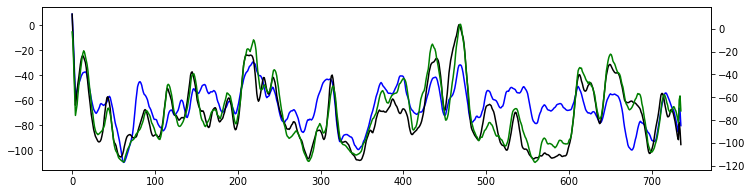

In [20]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(running_mean(qr_net_M2,8),'b')
#ax.plot(running_mean(qr_test,8),'r')
ax2 = ax.twinx()
ax2.plot(running_mean(qr_net_ce,8),'k')
ax2.plot(running_mean(qr_net_E5,8),'g')
#ax.set_ylim([160,280])
#ax2.set_ylim([160,280])

In [21]:
## ERA5 surface fluxes
os.chdir('/data/willytsai/ISCCP/dynamo_ssa/ERA5/RAD')

data = xr.open_dataset('ERA5_fluxes.nc'); data = data.sel(latitude=slice(0,-8),longitude=slice(72.5,80.5))
data2 = xr.open_dataset('ERA5_prec.nc'); data2 = data2.sel(latitude=slice(0,-8),longitude=slice(72.5,80.5))
lhf_sm = data.slhf
shf_sm = data.sshf

LHF_E5 = -lhf_sm.mean(axis=(1,2)).resample(time='3H').nearest()/3600
SHF_E5 = -shf_sm.mean(axis=(1,2)).resample(time='3H').nearest()/3600

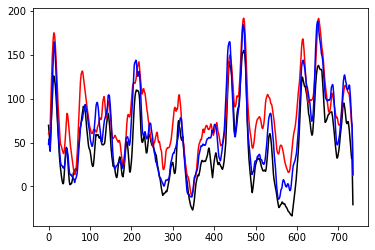

In [22]:
plt.plot(running_mean(qr_net_ce+SHF+LHF,8),'k')
plt.plot(running_mean(qr_net_M2+SHF_M2+LHF_M2,8),'r')
plt.plot(running_mean(qr_net_E5+SHF_E5+LHF_E5,8),'b')

In [23]:
##### load ERA5 precipitation
os.chdir('/data/willytsai/ISCCP/dynamo_ssa/ERA5')
prec_E5 = np.zeros((736))

data = xr.open_dataset('ERA5_prec.nc'); data = data.sel(latitude=slice(0,-8),longitude=slice(72.5,80.5))
prec_sm = data.tp.resample(time='3H').nearest()
prec_E5 = np.nanmean(prec_sm,axis=(1,2))/3600*100*10*24*3600 # mm/d

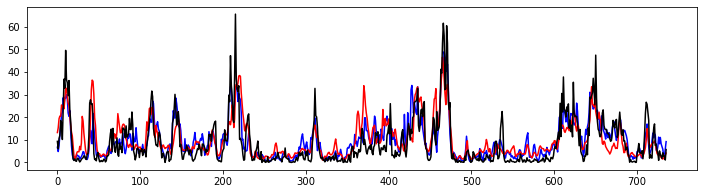

In [24]:
# all precip datasets, TRMM, M2, E5
fig = plt.figure(figsize=(12,3))
plt.plot(prec_E5,'b')
plt.plot(24*3600*prec_M2,'r')
plt.plot(prec,'k')

In [25]:
os.chdir('/data/willytsai/ISCCP/dynamo_ssa/ERA5')
omega_E5 = np.zeros((736,29)) # model level

data = xr.open_dataset('ERA5_omega.nc'); data = data.sel(latitude=slice(0,-8),longitude=slice(72.5,80.5))
omega_sm = data.w.resample(time='3H').nearest()
omega_E5 = omega_sm.mean(axis=(2,3))
lev_E5 = omega_sm.level

In [26]:
## load AIRS CWV
os.chdir('/data/willytsai/ISCCP/dynamo_ssa/AIRS')

cwv_AIRS = np.zeros((2,92)) # daily data, A,D tracks
files = glob('*nc4')

for n,file in enumerate(files):
    data = xr.open_dataset(file); data = data.sel(Latitude=slice(0,-8),Longitude=slice(72.5,80.5))
    cwv_AIRS[0,n] = (data.TotH2OVap_A).mean(axis=(0,1))
    cwv_AIRS[1,n] = (data.TotH2OVap_D).mean(axis=(0,1))

In [27]:
## load AIRS+AMSU CWV
os.chdir('/data/willytsai/ISCCP/dynamo_ssa/AIRS_AMSU')

cwv_AIRS_AMSU = np.zeros((2,92)) # daily data, A,D tracks
files = glob('*nc4')

for n,file in enumerate(files):
    data = xr.open_dataset(file); data = data.sel(Latitude=slice(0,-8),Longitude=slice(72.5,80.5))
    cwv_AIRS_AMSU[0,n] = (data.TotH2OVap_A).mean(axis=(0,1))
    cwv_AIRS_AMSU[1,n] = (data.TotH2OVap_D).mean(axis=(0,1))

In [28]:
# ### precip test 
# os.chdir('/data/willytsai/ISCCP/dynamo_ssa/ERA5')
# prec_E5 = np.zeros((736))
# data = xr.open_dataset('ERA5_prec.nc'); 
# data = data.sel(latitude=slice(0,-8),longitude=slice(72.5,80.5))
# prec_sm = data.tp.resample(time='3H').nearest()
# prec_E5 = np.nanmean(prec_sm,axis=(1,2))

# os.chdir('/data/willytsai/ISCCP/dynamo_ssa/MERRA2/SFX')
# files = sorted(glob('*.nc'))

# prec_M2 = np.zeros((736))
# prec_corr_M2 = np.zeros((736))

# for n,file in enumerate(files):
#     data = xr.open_dataset(file); data = data.sel(lat=slice(-8,0),lon=slice(72.5,80.5))
#     prec_sm = data.PRECTOT.resample(time='3H').nearest()
#     prec_corr_sm = data.PRECTOTCORR.resample(time='3H').nearest()
    
#     prec_M2[8*n:8*(n+1)] = np.nanmean(prec_sm,axis=(1,2))
#     prec_corr_M2[8*n:8*(n+1)] = np.nanmean(prec_corr_sm,axis=(1,2))

### Analysis part

In [29]:
# running mean for omega and fft difference
omega_RM = np.copy(omega)*0
omega_M2_RM = np.copy(omega_M2)*0
omega_E5_RM = np.copy(omega_E5)*0
rh_RM = np.copy(rh)*0
rh_M2_RM = np.copy(rh_M2)*0

omega_R = np.copy(omega)*0
omega_M2_R = np.copy(omega_M2)*0
omega_E5_R = np.copy(omega_E5)*0

for k in range(len(lev)):
    omega_RM[:,k] = running_mean(omega[:,k],3)    
    omega_R[:,k] = remove_diurnal_1D(omega[:,k])
    rh_RM[:,k] = running_mean(rh[:,k],3)
    
for k in range(len(lev_M2)):
    omega_M2_RM[:,k] =  running_mean(omega_M2[:,k],3)
    omega_M2_R[:,k] = remove_diurnal_1D(omega_M2[:,k])
    rh_M2_RM[:,k] =  running_mean(rh_M2[:,k],3)
    
for k in range(len(lev_E5)):
    omega_E5_RM[:,k] =  running_mean(omega_E5[:,k],3)
    omega_E5_R[:,k] = remove_diurnal_1D(omega_E5[:,k])

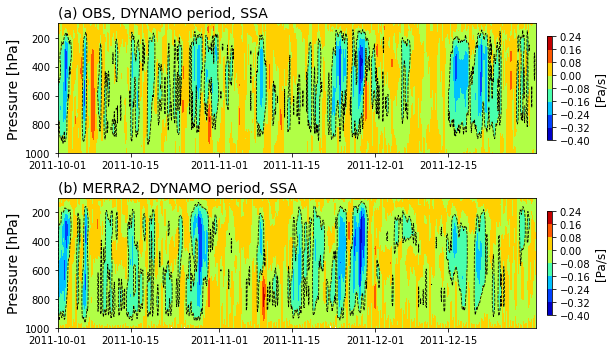

In [30]:
fig,ax = plt.subplots(2,1,figsize=(9,5))

cbar1 = ax[1].contourf(omega_sm.time.values,lev_M2,omega_M2.T, cmap='jet',
                       levels=np.linspace(-0.4,0.24,9))
ax[1].contour(omega_sm.time.values,lev_M2,omega_M2.T, colors=['k'],
                       levels=[-0.08],linewidths=0.8,linestyle='-')
ax[1].set_ylim([1000,100])
cb1 = plt.colorbar(cbar1,ax=ax[0], shrink=0.8, pad=0.02)
cb1.set_label('[Pa/s]',fontsize=12)

cbar2 = ax[0].contourf(omega_sm.time.values,lev,omega.T, cmap='jet',
                       levels=np.linspace(-0.4,0.24,9))
ax[0].contour(omega_sm.time.values,lev,omega.T, colors=['k'],
                       levels=[-0.08],linewidths=0.8,linestyle='-')
ax[0].set_ylim([1000,100])
cb2 = plt.colorbar(cbar2,ax=ax[1], shrink=0.8, pad=0.02)
cb2.set_label('[Pa/s]',fontsize=12)

ax[1].set_title('(b) MERRA2, DYNAMO period, SSA',fontsize=14,loc='left')
ax[0].set_title('(a) OBS, DYNAMO period, SSA',fontsize=14,loc='left')
ax[0].set_ylabel('Pressure [hPa]',fontsize=14)
ax[1].set_ylabel('Pressure [hPa]',fontsize=14)
#ax[0].set_xlim([0,480]);ax[1].set_xlim([0,480])
plt.tight_layout(w_pad=1)
plt.show()

#fig.savefig('/data/willytsai/ISCCP/fig/DYNAMO_omega_compare.pdf',bbox_inches='tight')

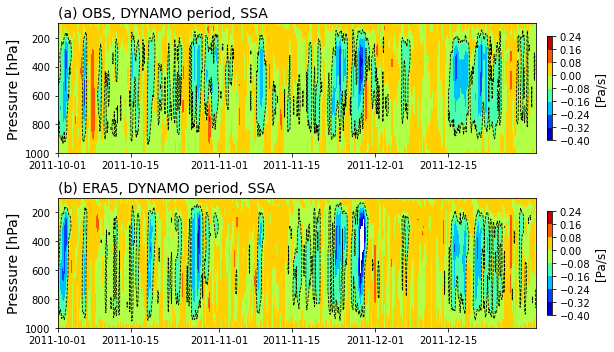

In [31]:
fig,ax = plt.subplots(2,1,figsize=(9,5))

cbar1 = ax[1].contourf(omega_sm.time.values,lev_E5,omega_E5.T, cmap='jet',
                       levels=np.linspace(-0.4,0.24,9))
ax[1].contour(omega_sm.time.values,lev_E5,omega_E5.T, colors=['k'],
                       levels=[-0.08],linewidths=0.8,linestyle='-')
ax[1].set_ylim([1000,100])
cb1 = plt.colorbar(cbar1,ax=ax[0], shrink=0.8, pad=0.02)
cb1.set_label('[Pa/s]',fontsize=12)

cbar2 = ax[0].contourf(omega_sm.time.values,lev,omega.T, cmap='jet',
                       levels=np.linspace(-0.4,0.24,9))
ax[0].contour(omega_sm.time.values,lev,omega.T, colors=['k'],
                       levels=[-0.08],linewidths=0.8,linestyle='-')
ax[0].set_ylim([1000,100])
cb2 = plt.colorbar(cbar2,ax=ax[1], shrink=0.8, pad=0.02)
cb2.set_label('[Pa/s]',fontsize=12)

ax[1].set_title('(b) ERA5, DYNAMO period, SSA',fontsize=14,loc='left')
ax[0].set_title('(a) OBS, DYNAMO period, SSA',fontsize=14,loc='left')
ax[0].set_ylabel('Pressure [hPa]',fontsize=14)
ax[1].set_ylabel('Pressure [hPa]',fontsize=14)
#ax[0].set_xlim([0,480]);ax[1].set_xlim([0,480])
plt.tight_layout(w_pad=1)
plt.show()

fig.savefig('/data/willytsai/ISCCP/fig/DYNAMO_omega_compare_ERA5.pdf',bbox_inches='tight')

In [32]:
# fig,ax = plt.subplots(1,1,figsize=(12,3))

# cbar1 = ax.contourf(omega_sm.time.values,lev_M2,omega_M2.T, cmap='jet',
#                        levels=np.linspace(-0.4,0.24,9))
# ax.contour(omega_sm.time.values,lev_E5,omega_E5.T, colors=['k'],
#                        levels=[-0.08],linewidths=0.8,linestyle='-')
# ax.set_ylim([1000,100])
# #cb1 = plt.colorbar(cbar1,ax=ax, shrink=0.8, pad=0.02)
# #cb1.set_label('[Pa/s]',fontsize=12)
# ax.set_xlim([datetime(2011,9,30),datetime(2012,1,1)])
# ax.set_title('(c) MERRA-2, DYNAMO period, SSA',fontsize=14,loc='left')
# ax.set_ylabel('Pressure [hPa]',fontsize=14)

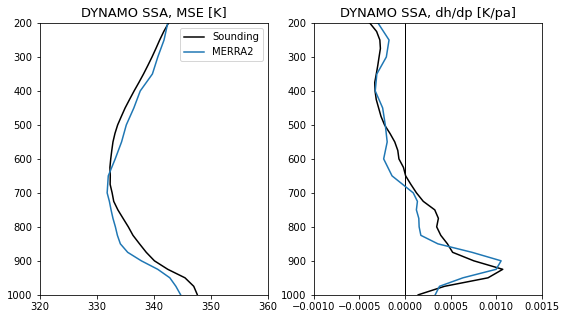

In [33]:
fig,ax = plt.subplots(1,2,figsize=(9,5))
ax[0].plot(np.nanmean(1004*(T+273.15) + 9.8*z + 2.5e6*q/1000,axis=0)/1000,lev,'-k')
ax[0].plot(np.nanmean(1004*T_M2++ 2.5e6*q_M2+9.8*z_M2,axis=0)/1000,lev_M2)
ax[0].set_ylim([1000,200])
ax[0].set_xlim([320,360])

ax[1].plot(np.gradient(h.mean(axis=0)/1000,lev*100),lev,'-k')
ax[1].plot(np.gradient(np.nanmean(1004*T_M2+2.5e6*q_M2+9.8*z_M2,axis=0)/1000,lev_M2*100),lev_M2)
ax[1].set_ylim([1000,200])
ax[1].set_xlim([-1e-3,1.5e-3])
ax[1].vlines(x=0,ymin=200,ymax=1000,color='k',linewidth=1)

ax[0].set_title('DYNAMO SSA, MSE [K]',fontsize=13)
ax[1].set_title('DYNAMO SSA, dh/dp [K/pa]',fontsize=13)
ax[0].legend(['Sounding','MERRA2'])

In [34]:
date_3hr = []; date_begin = datetime(2011,10,1)
for t in range(736):
    tmp = date_begin + t*timedelta(hours=3)
    date_3hr.append(tmp)
    
date_daily = []; date_begin = datetime(2011,10,1)
for t in range(92):
    tmp = date_begin + t*timedelta(days=1)
    date_daily.append(tmp)

In [35]:
#Abar = np.sqrt((cldfrac*640000)/N) # averaged cloud size [km] 

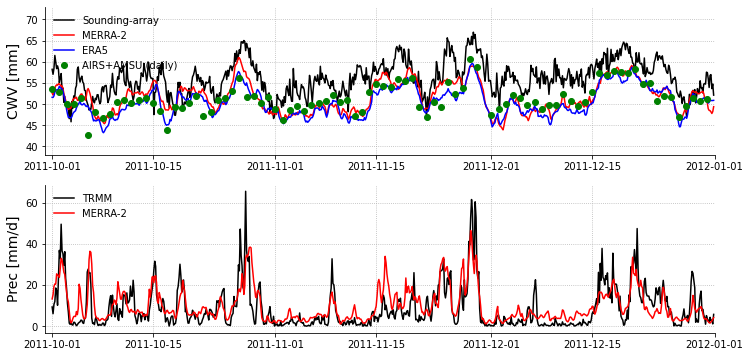

In [36]:
fig,ax = plt.subplots(2,1,figsize=(12,6))
ax[0].plot(date_3hr,cwv,'k')
ax[0].plot(date_3hr,cwv_M2,'r')
ax[0].plot(date_3hr,cwv_E5,'b')
#ax[0].plot(date_daily,cwv_AIRS[:,:].mean(axis=0),'ob')
ax[0].plot(date_daily,cwv_AIRS_AMSU[:,:].mean(axis=0),'og')
ax[0].set_xlim([datetime(2011,9,30),datetime(2012,1,1)])
ax[0].legend(['Sounding-array','MERRA-2','ERA5','AIRS+AMSU (daily)'],framealpha=0,loc=2)
ax[0].set_ylim([38,73])
ax[0].grid(axis='both',linestyle=':')
ax[0].set_ylabel('CWV [mm]',fontsize=14)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

# precip, CWV, SCAI
ax[1].plot(date_3hr,prec,'k')
ax[1].plot(date_3hr,24*3600*prec_M2,'r')
ax[1].set_xlim([datetime(2011,9,30),datetime(2012,1,1)])
ax[1].grid(axis='both',linestyle=':')
ax[1].legend(['TRMM','MERRA-2'],framealpha=0,loc=2)
ax[1].set_ylabel('Prec [mm/d]',fontsize=14)

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

ax[1].set_xlim([datetime(2011,9,30),datetime(2012,1,1)])

#plt.title('DYNAMO, CWV time-series, SSA',fontsize=14)
plt.savefig('/data/willytsai/ISCCP/fig/DYNAMO_CWV_compare.pdf',bbox_inches='tight')

In [ ]:
# fig,ax = plt.subplots(1,1,figsize=(12,3))
# #ax.plot(date_3hr,cldfrac)

# ax.plot(date_3hr,running_mean(Abar,3))
# ax.set_xlim([datetime(2011,9,30),datetime(2012,1,1)])
# ax.set_ylabel('Abar [km]',fontsize=14)

In [ ]:
# fig,ax = plt.subplots(1,1,figsize=(12,3))
# #ax.plot(date_3hr,cwv_M2,'b',label='cwv')
# ax.plot(date_3hr,running_mean(cwv_M2,40),color='royalblue',linewidth=3,alpha=0.4,label='cwv, 5DRM')
# ax.plot(date_3hr,running_mean(cwv_M2,80),color='blue',linewidth=3,alpha=0.4,label='cwv, 10DRM')
# #ax.plot(date_3hr,Md,color='red',linewidth=3,alpha=0.4,label='cwv, 10DRM')

# ax1 = ax.twinx()
# ax1.plot(date_3hr,running_mean(SCAI_BT,8),'-g',markersize=3,label='SCAI, 1DRM')
# ax2 = ax.twinx()
# ax2.spines["right"].set_position(("axes", 1.07))

# ax2.bar(date_3hr,prec,color='lightgrey',alpha=0.9,edgecolor='None',width=0.1)
# ax.set_xlim([datetime(2011,9,30),datetime(2012,1,1)])
# #ax.legend(['Sounding-array','MERRA-2','AIRS'],framealpha=0,loc=2)
# #ax.set_ylim([38,73])
# ax.grid(axis='both',linestyle=':')
# ax.set_ylabel('CWV [mm]',fontsize=14)
# ax1.set_ylabel('SCAI',color='g',fontsize=14)
# ax2.set_ylabel('prec [mm/d]',color='grey',fontsize=14)
# ax.set_ylim([40,65])
# ax.legend();ax1.legend(loc=2)

# # ax.spines['right'].set_visible(False)
# # ax[0].spines['top'].set_visible(False)
# plt.savefig('/data/willytsai/ISCCP/fig/cwv_SCAI_prec.pdf',bbox_inches='tight')

### Running mean comparison

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(10,5))

cbar1 = ax[1].contourf(omega_sm.time.values,lev_M2,omega_M2_RM.T, cmap='jet',
                       levels=np.linspace(-0.4,0.24,9))
ax[1].contour(omega_sm.time.values,lev_M2,omega_M2_RM.T, colors=['k'],
                       levels=[-0.08],linewidths=0.8,linestyle='-')
ax[1].set_ylim([1000,100])
cb1 = plt.colorbar(cbar1,ax=ax[0], shrink=0.8, pad=0.02)
cb1.set_label('[Pa/s]',fontsize=12)

cbar2 = ax[0].contourf(omega_sm.time.values,lev,omega_RM.T, cmap='jet',
                       levels=np.linspace(-0.4,0.24,9))
ax[0].contour(omega_sm.time.values,lev,omega_RM.T, colors=['k'],
                       levels=[-0.08],linewidths=0.8,linestyle='-')
ax[0].set_ylim([1000,100])
cb2 = plt.colorbar(cbar2,ax=ax[1], shrink=0.8, pad=0.02)
cb2.set_label('[Pa/s]',fontsize=12)

ax[1].set_title('(b) MERRA2, DYNAMO period, SSA',fontsize=14,loc='left')
ax[0].set_title('(a) OBS, DYNAMO period, SSA',fontsize=14,loc='left')
ax[0].set_ylabel('Pressure [hPa]',fontsize=14)
ax[1].set_ylabel('Pressure [hPa]',fontsize=14)
#ax[0].set_xlim([0,480]);ax[1].set_xlim([0,480])
plt.tight_layout(w_pad=1)
plt.show()

#fig.savefig('/data/willytsai/ISCCP/fig/DYNAMO_omega_compare.pdf',bbox_inches='tight')

In [ ]:
from scipy import interpolate

In [ ]:
test = np.fliplr(omega_E5_RM)

In [ ]:
# interpolate into the same pressure coordinate
omega_M2_intp = np.zeros((736,39))
omega_E5_intp = np.zeros((736,39))
omega_E5_RM = np.fliplr(omega_E5_RM)

# linear interp MERRA-2 into obs sounding
for t in range(omega.shape[0]):
    x = lev_M2[:27] # 1000-50hpa
    x2 = lev_E5[:-8] # 1000-50hpa
    xnew = lev[1:]

    f = interpolate.interp1d(x, omega_M2_RM[t,:27], kind='linear')
    f2 = interpolate.interp1d(x2, omega_E5_RM[t,:-8], kind='linear')
    omega_M2_intp[t,:] = f(xnew)
    omega_E5_intp[t,:] = f2(xnew)

In [ ]:
fig = plt.figure(figsize=(5,5))
num = 230
plt.plot(omega_M2_intp[num,:],lev[1:],'b')
plt.plot(omega_M2_intp[num,:]*(prec_rm6[num]/(24*3600*prec_M2_rm6[num])),lev[1:],'--b')
plt.plot(omega_E5_intp[num,:],lev[1:],'-r')
plt.plot(omega_E5_intp[num,:]*(prec_rm6[num]/(24*prec_E5_rm6[num]*1000)),lev[1:],'--r')
plt.plot(omega[num,:],lev,'-k')

plt.ylim([1000,100])
plt.legend(['MERRA-2','MERRA-2, rescaled','ERA5','ERA5, rescaled','Sondes'])
plt.xlabel('omega [Pa/s]',fontsize=12)
#fig.savefig('/data/willytsai/ISCCP/fig/omega_rescale_test.pdf',bbox_inches='tight')

In [ ]:
## vint omega'^2 over the period
diff_scale = (omega_RM[:,1:].T-omega_M2_intp[:,:].T*(prec_rm6/(24*3600*prec_M2_rm6)))**2
diff = (omega_RM[:,1:].T-omega_M2_intp[:,:].T)**2
diff_scale_E5 = (omega_RM[:,1:].T-omega_E5_intp[:,:].T*(prec_rm6/(24*prec_E5_rm6*1000)))**2

In [ ]:
idx_pcri = np.where(prec>0)[0]

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.nanmean(diff_scale[:,idx_pcri],axis=1)**0.5,lev[1:],'--b')
plt.plot(np.nanmean(diff[:,idx_pcri],axis=1)**0.5,lev[1:],'b')
plt.plot(np.nanmean(diff_scale_E5[:,idx_pcri],axis=1)**0.5,lev[1:],'--r')

plt.ylim([1000,100])
plt.legend(['MERRA-2, rescaled','MERRA-2','ERA5, rescaled'])
plt.title('RMSE, omega',fontsize=12)
#plt.xticks([0,0.001,0.002,0.003,0.004]);
plt.xlabel('[Pa/s]',fontsize=12)
fig.savefig('/data/willytsai/ISCCP/fig/omega_rescale_devia.pdf',bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(9,5))

cbar1 = ax[0].contourf(range(736),lev_M2,100*rh_M2.T, cmap='jet',
                       levels=np.linspace(35,95,11))
ax[0].set_ylim([1000,100])
plt.colorbar(cbar1,ax=ax[0], shrink=0.8, pad=0.02)

cbar2 = ax[1].contourf(range(736),lev,rh.T, cmap='jet',
                       levels=np.linspace(35,95,11))
ax[1].set_ylim([1000,100])
plt.colorbar(cbar2,ax=ax[1], shrink=0.8, pad=0.02)

ax[0].set_title('(a) MERRA2, DYNAMO period, SSA',fontsize=14,loc='left')
ax[1].set_title('(b) OBS, DYNAMO period, SSA',fontsize=14,loc='left')
ax[0].set_ylabel('Pressure [hPa]',fontsize=14)
ax[1].set_ylabel('Pressure [hPa]',fontsize=14)
#ax[0].set_xlim([0,480]);ax[1].set_xlim([0,480])
plt.tight_layout(w_pad=1)
plt.show()

#fig.savefig('/data/willytsai/ISCCP/fig/DYNAMO_omega_compare.pdf',bbox_inches='tight')

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(10,5))

cf=ax[0].contourf(obs_time,lev,h_adv[:,:].T,cmap='jet')
cbaxes = inset_axes(ax[0], width="5%",height="70%",loc='lower left',
                   bbox_to_anchor=(1.02, 0.2, 1, 1),bbox_transform=ax[0].transAxes,
                   borderpad=0) 
cbar=fig.colorbar(cf,cax=cbaxes,orientation='vertical')

#cbar.set_label('[mm]')
ax[0].set_ylim([1000,100])
ax[1].plot(obs_time,prec)

ax[0].set_title(r'DYNAMO array-averaged horizontal MSE export, V$\nabla\cdot$h',fontsize=14)
ax[0].set_ylabel('hPa',fontsize=12)
ax[1].set_ylabel('[mm/d]',fontsize=12)

ax[0].set_xlim([datetime(2011,11,18),datetime(2011,12,5)])
ax[1].set_xlim([datetime(2011,11,18),datetime(2011,12,5)])

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(10,5))

cf=ax[0].contourf(obs_time,lev_M2[:25],h_adv_M2[:,:25].T,cmap='jet',levels=np.linspace(-0.16,0.16,9))
cbaxes = inset_axes(ax[0], width="5%",height="70%",loc='lower left',
                   bbox_to_anchor=(1.02, 0.2, 1, 1),bbox_transform=ax[0].transAxes,
                   borderpad=0) 
cbar=fig.colorbar(cf,cax=cbaxes,orientation='vertical')
#cbar.set_label('[mm]')
ax[0].set_ylim([1000,100])
ax[1].plot(obs_time,prec)

ax[0].set_title(r'DYNAMO MERRA-2 horizontal MSE export, V$\nabla\cdot$h',fontsize=14)
ax[0].set_ylabel('hPa',fontsize=12)
ax[1].set_ylabel('[mm/d]',fontsize=12)

ax[0].set_xlim([datetime(2011,11,18),datetime(2011,12,5)])
ax[1].set_xlim([datetime(2011,11,18),datetime(2011,12,5)])

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(10,5))

cf=ax[0].contourf(obs_time,lev_M2[:25],hdwdp_M2[:,:25].T,cmap='jet')#levels=np.linspace(-0.16,0.16,9))
cbaxes = inset_axes(ax[0], width="5%",height="70%",loc='lower left',
                   bbox_to_anchor=(1.02, 0.2, 1, 1),bbox_transform=ax[0].transAxes,
                   borderpad=0) 
cbar=fig.colorbar(cf,cax=cbaxes,orientation='vertical')
#cbar.set_label('[mm]')
ax[0].set_ylim([1000,100])
ax[1].plot(obs_time,prec)
ax[0].set_title('DYNAMO MERRA-2 MSE divergence',fontsize=14)
ax[0].set_ylabel('hPa',fontsize=12)
ax[1].set_ylabel('[mm/d]',fontsize=12)

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(10,5))

cf=ax[0].contourf(obs_time,lev_M2[:25],wdhdp_M2[:,:25].T,cmap='jet')#levels=np.linspace(-0.16,0.16,9))
cbaxes = inset_axes(ax[0], width="5%",height="70%",loc='lower left',
                   bbox_to_anchor=(1.02, 0.2, 1, 1),bbox_transform=ax[0].transAxes,
                   borderpad=0) 
cbar=fig.colorbar(cf,cax=cbaxes,orientation='vertical')
#cbar.set_label('[mm]')
ax[0].set_ylim([1000,100])
ax[1].plot(obs_time,prec)
ax[0].set_title('DYNAMO MERRA-2 MSE divergence',fontsize=14)
ax[0].set_ylabel('hPa',fontsize=12)
ax[1].set_ylabel('[mm/d]',fontsize=12)

### SCAI schematic

In [ ]:
idx = np.where(SCAI_BT > 1)[0]
idy = np.where(np.logical_and(prec>25,prec<=30))[0]
idc = np.intersect1d(idx,idy)

In [ ]:
idc

In [ ]:
t=607
fig,ax = plt.subplots(2,2,figsize=(11,8))
cf1 = ax[0,0].pcolor(bt.lon,bt.lat,BT[t,:,:].T,cmap='Blues',vmin=240,vmax=300)
cbar = plt.colorbar(cf1,ax=ax[0,0],shrink=0.8)
cbar.set_label('[K]',fontsize=14)
#ax[0,0].set_xlabel('Longitude',fontsize=15)
#ax[0,0].set_ylabel('Latitude',fontsize=15)

label_tmp = label_map[t,:,:]
cmap_new = plt.get_cmap('nipy_spectral',label_tmp[~np.isnan(label_tmp)].max()) # get discrete colormap
cf2 = ax[0,1].pcolor(bt.lon,bt.lat,label_map[t,:,:].T,cmap=cmap_new,vmin=0,vmax=label_tmp[~np.isnan(label_tmp)].max())
#ax[0,1].set_xlabel('Longitude',fontsize=15)
#ax[0,1].set_ylabel('Latitude',fontsize=15)
ax[0,1].text(77.6,-6.3,'SCAI='+str(round(SCAI_BT[t],2)),fontsize=14.5,color='k')
ax[0,1].text(77.6,-6.9,'N='+str(int(N[t])),fontsize=14.5,color='k')
ax[0,1].text(77.6,-7.5,'P='+str(round(prec[t],1)),fontsize=14.5,color='k')

ax[0,0].set_title('(a)',fontsize=20,loc='left')
ax[0,1].set_title('(b)',fontsize=20,loc='left')
cbar2 = plt.colorbar(cf2,ax=ax[0,1],shrink=0.8)
cbar2.set_label('Label',fontsize=14)
#ax[1].grid()
#fig.savefig('/data/willytsai/ISCCP/fig/SCAI_demo_T377.pdf',bbox_inches='tight')

t=42
cf3 = ax[1,0].pcolor(bt.lon,bt.lat,BT[t,:,:].T,cmap='Blues',vmin=240,vmax=300)
cbar3 = plt.colorbar(cf3,ax=ax[1,0],shrink=0.8)
cbar3.set_label('[K]',fontsize=14)
#ax[1,0].set_xlabel('Longitude',fontsize=15)
#ax[1,0].set_ylabel('Latitude',fontsize=15)
#ax[0].grid()

label_tmp = label_map[t,:,:]
cmap_new = plt.get_cmap('nipy_spectral',label_tmp[~np.isnan(label_tmp)].max()) # get discrete colormap
cf4 = ax[1,1].pcolor(bt.lon,bt.lat,label_map[t,:,:].T,cmap=cmap_new,vmin=0,vmax=label_tmp[~np.isnan(label_tmp)].max())
#ax[1,1].set_xlabel('Longitude',fontsize=15)
#ax[1,1].set_ylabel('Latitude',fontsize=15)
ax[1,1].text(77.6,-6.3,'SCAI='+str(round(SCAI_BT[t],2)),fontsize=14.5,color='k')
ax[1,1].text(77.6,-6.9,'N='+str(int(N[t])),fontsize=14.5,color='k')
ax[1,1].text(77.6,-7.5,'P='+str(round(prec[t],1)),fontsize=14.5,color='k')

ax[1,0].set_title('(c)',fontsize=20,loc='left')
ax[1,1].set_title('(d)',fontsize=20,loc='left')
cbar4 = plt.colorbar(cf4,ax=ax[1,1],shrink=0.8)
cbar4.set_label('Label',fontsize=14)

#fig.savefig('/data/willytsai/ISCCP/fig/SCAI_demo_merged.pdf',bbox_inches='tight')

In [ ]:
t=206
fig,ax = plt.subplots(2,2,figsize=(11,8))
cf1 = ax[0,0].pcolor(bt.lon,bt.lat,BT[t,:,:].T,cmap='Blues',vmin=240,vmax=300)
cbar = plt.colorbar(cf1,ax=ax[0,0],shrink=0.8)
cbar.set_label('[K]',fontsize=14)
#ax[0,0].set_xlabel('Longitude',fontsize=15)
#ax[0,0].set_ylabel('Latitude',fontsize=15)

label_tmp = label_map[t,:,:]
cmap_new = plt.get_cmap('nipy_spectral',label_tmp[~np.isnan(label_tmp)].max()) # get discrete colormap
cf2 = ax[0,1].pcolor(bt.lon,bt.lat,label_map[t,:,:].T,cmap=cmap_new,vmin=0,vmax=label_tmp[~np.isnan(label_tmp)].max())
#ax[0,1].set_xlabel('Longitude',fontsize=15)
#ax[0,1].set_ylabel('Latitude',fontsize=15)
ax[0,1].text(77.6,-6.3,'SCAI='+str(round(SCAI_BT[t],2)),fontsize=14.5,color='k')
ax[0,1].text(77.6,-6.9,'N='+str(int(N[t])),fontsize=14.5,color='k')
ax[0,1].text(77.6,-7.5,'P='+str(round(prec[t],1)),fontsize=14.5,color='k')

ax[0,0].set_title('(a)',fontsize=20,loc='left')
ax[0,1].set_title('(b)',fontsize=20,loc='left')
cbar2 = plt.colorbar(cf2,ax=ax[0,1],shrink=0.8)
cbar2.set_label('Label',fontsize=14)
#ax[1].grid()
#fig.savefig('/data/willytsai/ISCCP/fig/SCAI_demo_T377.pdf',bbox_inches='tight')

t=618
cf3 = ax[1,0].pcolor(bt.lon,bt.lat,BT[t,:,:].T,cmap='Blues',vmin=240,vmax=300)
cbar3 = plt.colorbar(cf3,ax=ax[1,0],shrink=0.8)
cbar3.set_label('[K]',fontsize=14)
#ax[1,0].set_xlabel('Longitude',fontsize=15)
#ax[1,0].set_ylabel('Latitude',fontsize=15)
#ax[0].grid()

label_tmp = label_map[t,:,:]
cmap_new = plt.get_cmap('nipy_spectral',label_tmp[~np.isnan(label_tmp)].max()) # get discrete colormap
cf4 = ax[1,1].pcolor(bt.lon,bt.lat,label_map[t,:,:].T,cmap=cmap_new,vmin=0,vmax=label_tmp[~np.isnan(label_tmp)].max())
#ax[1,1].set_xlabel('Longitude',fontsize=15)
#ax[1,1].set_ylabel('Latitude',fontsize=15)
ax[1,1].text(77.6,-6.3,'SCAI='+str(round(SCAI_BT[t],2)),fontsize=14.5,color='k')
ax[1,1].text(77.6,-6.9,'N='+str(int(N[t])),fontsize=14.5,color='k')
ax[1,1].text(77.6,-7.5,'P='+str(round(prec[t],1)),fontsize=14.5,color='k')

ax[1,0].set_title('(c)',fontsize=20,loc='left')
ax[1,1].set_title('(d)',fontsize=20,loc='left')
cbar4 = plt.colorbar(cf4,ax=ax[1,1],shrink=0.8)
cbar4.set_label('Label',fontsize=14)

fig.savefig('/data/willytsai/ISCCP/fig/SCAI_demo_merged.pdf',bbox_inches='tight')

In [ ]:
# t=377
# fig,ax = plt.subplots(2,2,figsize=(11,8))
# cf1 = ax[0,0].pcolor(bt.lon,bt.lat,BT[t,:,:].T,cmap='Blues',vmin=240,vmax=300)
# cbar = plt.colorbar(cf1,ax=ax[0,0],shrink=0.8)
# cbar.set_label('[K]',fontsize=14)
# #ax[0,0].set_xlabel('Longitude',fontsize=15)
# #ax[0,0].set_ylabel('Latitude',fontsize=15)

# label_tmp = label_map[t,:,:]
# cmap_new = plt.get_cmap('nipy_spectral',label_tmp[~np.isnan(label_tmp)].max()) # get discrete colormap
# cf2 = ax[0,1].pcolor(bt.lon,bt.lat,label_map[t,:,:].T,cmap=cmap_new,vmin=0,vmax=label_tmp[~np.isnan(label_tmp)].max())
# #ax[0,1].set_xlabel('Longitude',fontsize=15)
# #ax[0,1].set_ylabel('Latitude',fontsize=15)
# ax[0,1].text(77.6,-6.3,'SCAI='+str(round(SCAI_BT[t],2)),fontsize=14.5,color='k')
# ax[0,1].text(77.6,-6.9,'N='+str(int(N[t])),fontsize=14.5,color='k')
# ax[0,1].text(77.6,-7.5,'P='+str(round(prec[t],1)),fontsize=14.5,color='k')

# ax[0,0].set_title('(a)',fontsize=20,loc='left')
# ax[0,1].set_title('(b)',fontsize=20,loc='left')
# cbar2 = plt.colorbar(cf2,ax=ax[0,1],shrink=0.8)
# cbar2.set_label('Label',fontsize=14)
# #ax[1].grid()
# #fig.savefig('/data/willytsai/ISCCP/fig/SCAI_demo_T377.pdf',bbox_inches='tight')

# t=108
# cf3 = ax[1,0].pcolor(bt.lon,bt.lat,BT[t,:,:].T,cmap='Blues',vmin=240,vmax=300)
# cbar3 = plt.colorbar(cf3,ax=ax[1,0],shrink=0.8)
# cbar3.set_label('[K]',fontsize=14)
# #ax[1,0].set_xlabel('Longitude',fontsize=15)
# #ax[1,0].set_ylabel('Latitude',fontsize=15)
# #ax[0].grid()

# label_tmp = label_map[t,:,:]
# cmap_new = plt.get_cmap('nipy_spectral',label_tmp[~np.isnan(label_tmp)].max()) # get discrete colormap
# cf4 = ax[1,1].pcolor(bt.lon,bt.lat,label_map[t,:,:].T,cmap=cmap_new,vmin=0,vmax=label_tmp[~np.isnan(label_tmp)].max())
# #ax[1,1].set_xlabel('Longitude',fontsize=15)
# #ax[1,1].set_ylabel('Latitude',fontsize=15)
# ax[1,1].text(77.6,-6.3,'SCAI='+str(round(SCAI_BT[t],2)),fontsize=14.5,color='k')
# ax[1,1].text(77.6,-6.9,'N='+str(int(N[t])),fontsize=14.5,color='k')
# ax[1,1].text(77.6,-7.5,'P='+str(round(prec[t],1)),fontsize=14.5,color='k')

# ax[1,0].set_title('(c)',fontsize=20,loc='left')
# ax[1,1].set_title('(d)',fontsize=20,loc='left')
# cbar4 = plt.colorbar(cf4,ax=ax[1,1],shrink=0.8)
# cbar4.set_label('Label',fontsize=14)

# fig.savefig('/data/willytsai/ISCCP/fig/SCAI_demo_merged.pdf',bbox_inches='tight')

### !!!! GMS components

In [36]:
# OBS
s_adv = dse_data[:,:,2] + dse_data[:,:,3]
wdsdp = dse_data[:,:,4]
h_adv = mse_data[:,:,2] + mse_data[:,:,3]
wdhdp = mse_data[:,:,4]
#s_adv = 1004*hT ; wdsdp = 1004*vT 
#h_adv = 1004*hT + 2.5e6*hq ; wdhdp = 1004*vT + 2.5e6*vq

del_sv = s_adv + wdsdp
del_hv = h_adv + wdhdp

vint_sadv = -(1/9.8)*np.trapz(s_adv[:,:-2],lev[:-2]*100,axis=1)
vint_wdsdp = -(1/9.8)*np.trapz(wdsdp[:,:-2],lev[:-2]*100,axis=1)
vint_hadv = -(1/9.8)*np.trapz(h_adv[:,:-2],lev[:-2]*100,axis=1)
vint_wdhdp = -(1/9.8)*np.trapz(wdhdp[:,:-2],lev[:-2]*100,axis=1)

vint_del_sv = -(1/9.8)*np.trapz(del_sv[:,:-2],lev[:-2]*100,axis=1)
vint_del_hv = -(1/9.8)*np.trapz(del_hv[:,:-2],lev[:-2]*100,axis=1)

# MERRA2 
vint_sadv_M2 = -(1/9.8)*np.trapz(s_adv_M2[:,:25],lev_M2[:25]*100,axis=1)
vint_wdsdp_M2 = -(1/9.8)*np.trapz(wdsdp_M2[:,:25],lev_M2[:25]*100,axis=1)
vint_hadv_M2 = -(1/9.8)*np.trapz(h_adv_M2[:,:25],lev_M2[:25]*100,axis=1)
vint_wdhdp_M2 = -(1/9.8)*np.trapz(wdhdp_M2[:,:25],lev_M2[:25]*100,axis=1)

vint_del_sv_M2 = vint_sadv_M2 + vint_wdsdp_M2
vint_del_hv_M2 = vint_hadv_M2 + vint_wdhdp_M2

#ERA5 
vint_sadv_E5 = (1/9.8)*np.trapz(s_adv_E5[:,-27:],lev_E5[-27:]*100,axis=1)
vint_wdsdp_E5 = (1/9.8)*np.trapz(-wdsdp_E5[:,-27:],lev_E5[-27:]*100,axis=1) # negative sign for order consistency
vint_hadv_E5 = (1/9.8)*np.trapz(h_adv_E5[:,-27:],lev_E5[-27:]*100,axis=1)
vint_wdhdp_E5 = (1/9.8)*np.trapz(wdhdp_E5[:,-27:],lev_E5[-27:]*100,axis=1)

vint_del_sv_E5 = vint_sadv_E5 + vint_wdsdp_E5
vint_del_hv_E5 = vint_hadv_E5 + vint_wdhdp_E5

### Running mean 1-D

In [37]:
# applying one-day running average over 3hrly data
# OBS
qr_net = running_mean(qr_net, window_N=8)
S = running_mean(S, window_N=8)
F = running_mean(F, window_N=8)
vint_del_sv = running_mean(vint_del_sv, window_N=8)
vint_del_hv = running_mean(vint_del_hv, window_N=8)
vint_sadv = running_mean(vint_sadv, window_N=8)
vint_hadv = running_mean(vint_hadv, window_N=8)
vint_wdhdp = running_mean(vint_wdhdp, window_N=8)
vint_wdsdp = running_mean(vint_wdsdp, window_N=8)
prec = running_mean(prec, window_N=8)

T = running_mean2d(T, window_N=8)
q = running_mean2d(q, window_N=8)
rh = running_mean2d(rh, window_N=8)
omega = running_mean2d(omega, window_N=8)

In [38]:
# MERRA2
S_M2 = SHF_M2 + LHF_M2
F_M2 = S_M2 + qr_net_M2 
qr_net_M2 = running_mean(qr_net_M2, window_N=8)
S_M2 = running_mean(S_M2, window_N=8)
F_M2 = running_mean(F_M2, window_N=8)
vint_del_sv_M2 = running_mean(vint_del_sv_M2, window_N=8)
vint_del_hv_M2 = running_mean(vint_del_hv_M2, window_N=8)
vint_sadv_M2 = running_mean(vint_sadv_M2, window_N=8)
vint_hadv_M2 = running_mean(vint_hadv_M2, window_N=8)
vint_wdhdp_M2 = running_mean(vint_wdhdp_M2, window_N=8)
vint_wdsdp_M2 = running_mean(vint_wdsdp_M2, window_N=8)
prec_M2 = running_mean(prec_M2, window_N=8)

T_M2 = running_mean2d(T_M2, window_N=8)
q_M2 = running_mean2d(q_M2, window_N=8)
rh_M2 = running_mean2d(rh_M2, window_N=8)
omega_M2 = running_mean2d(omega_M2, window_N=8)

In [39]:
# ERA5
S_E5 = SHF_E5 + LHF_E5
F_E5 = S_E5 + qr_net_E5 
qr_net_E5 = running_mean(qr_net_E5, window_N=8)
S_E5 = running_mean(S_E5, window_N=8)
F_E5 = running_mean(F_E5, window_N=8)
vint_del_sv_E5 = running_mean(vint_del_sv_E5, window_N=8)
vint_del_hv_E5 = running_mean(vint_del_hv_E5, window_N=8)
vint_sadv_E5 = running_mean(vint_sadv_E5, window_N=8)
vint_hadv_E5 = running_mean(vint_hadv_E5, window_N=8)
vint_wdhdp_E5 = running_mean(vint_wdhdp_E5, window_N=8)
vint_wdsdp_E5 = running_mean(vint_wdsdp_E5, window_N=8)
prec_M2 = running_mean(prec_E5, window_N=8)

T_E5 = running_mean2d(T_E5, window_N=8)
q_E5 = running_mean2d(q_E5, window_N=8)
omega_E5 = running_mean2d(omega_E5, window_N=8)

In [40]:
date_3hr = []; date_begin = datetime(2011,10,1)
for t in range(736):
    tmp = date_begin + t*timedelta(hours=3)
    date_3hr.append(tmp)
    
date_daily = []; date_begin = datetime(2011,10,1)
for t in range(92):
    tmp = date_begin + t*timedelta(days=1)
    date_daily.append(tmp)

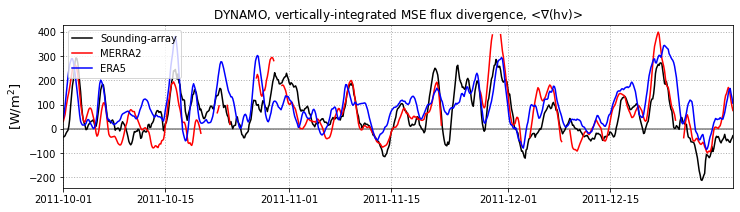

In [41]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(date_3hr,vint_del_hv,'k')
ax.plot(date_3hr,vint_del_hv_M2,'r')
ax.plot(date_3hr,vint_del_hv_E5,'b')
ax.hlines(y=0,xmin=date_3hr[0],xmax=date_3hr[-1],color='grey')
ax.legend(['Sounding-array','MERRA2','ERA5'],loc=2)
ax.grid(linestyle=':',linewidth=1)
ax.set_xlim([date_3hr[0],date_3hr[-1]])
ax.set_ylabel('[W/m$^2$]',fontsize=13)
ax.set_title(r'DYNAMO, vertically-integrated MSE flux divergence, <$\nabla$(hv)>')
fig.savefig('/data/willytsai/ISCCP/fig/vint_hv_comparison_M2_E5.pdf',bbox_inches='tight',dpi=300,
           transparent=False)

In [42]:
# Modified GMS considering effects of convergence and CWV gradient
M = (vint_hadv+vint_wdhdp)/vint_del_sv
Mc = F/vint_del_sv

# Modified GMS considering effects of convergence and CWV gradient
M_M2 = (vint_hadv_M2+vint_wdhdp_M2)/vint_del_sv_M2
Mc_M2 = F_M2/vint_del_sv_M2

# Modified GMS considering effects of convergence and CWV gradient
M_E5 = (vint_hadv_E5+vint_wdhdp_E5)/vint_del_sv_E5
Mc_E5 = F_E5/vint_del_sv_E5

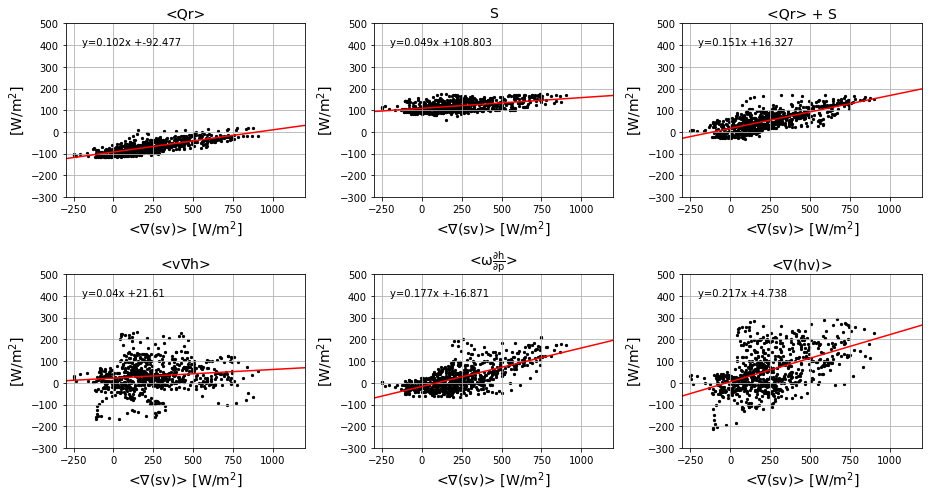

In [43]:
fig,ax = plt.subplots(2,3,figsize=(13,7))
ax_i = [0,0,0,1,1,1]; ax_j = [0,1,2,0,1,2]
titles = ['<Qr>','S','<Qr> + S',r'<v$\nabla$h>',r'<$\rm\omega \frac{\partial\rm h}{\partial\rm p}$>',r'<$\nabla$(hv)>']

for n, var in enumerate([qr_net, S, F, vint_hadv, vint_wdhdp, vint_del_hv]):
    
    i = ax_i[n]; j = ax_j[n]
    ax[i,j].scatter(vint_del_sv,var,s=5,color='k')
    # linear fitting
    slp,yint = np.polyfit(vint_del_sv,var,deg=1)
    ax[i,j].plot(np.linspace(-300,1200,100),slp*np.linspace(-300,1200,100)+yint,'r')
    ax[i,j].text(-200,400,'y='+str(round(slp,3))+'x +'+str(round(yint,3)))
    
    ax[i,j].set_xlim([-300,1200])
    ax[i,j].set_ylim([-300,500])
    ax[i,j].grid()
    ax[i,j].set_ylabel('[W/m$^2$]',fontsize=14)
    ax[i,j].set_xlabel(r'<$\nabla$(sv)> [W/m$^2$]',fontsize=14)
    ax[i,j].set_title(titles[n],fontsize=14)
plt.tight_layout()

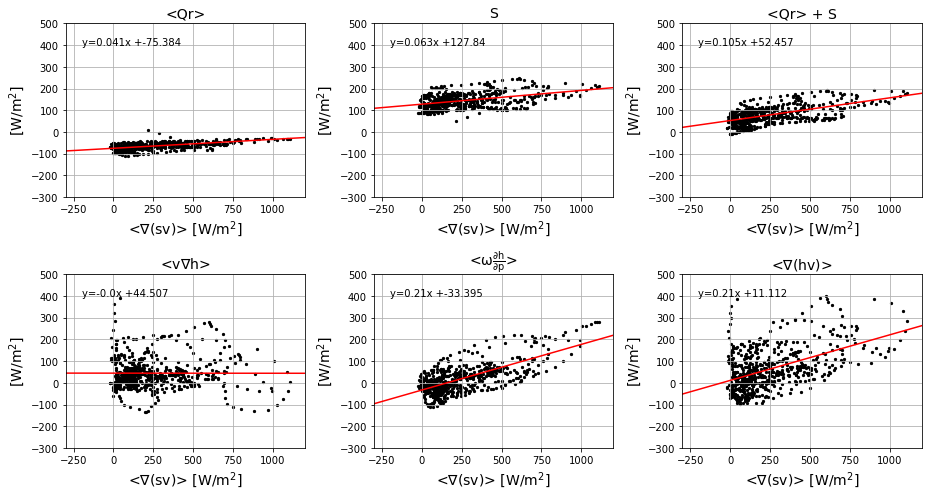

In [44]:
fig,ax = plt.subplots(2,3,figsize=(13,7))
ax_i = [0,0,0,1,1,1]; ax_j = [0,1,2,0,1,2]
titles = ['<Qr>','S','<Qr> + S',r'<v$\nabla$h>',r'<$\rm\omega \frac{\partial\rm h}{\partial\rm p}$>',r'<$\nabla$(hv)>']

for n, var in enumerate([qr_net_M2, S_M2, F_M2, vint_hadv_M2, vint_wdhdp_M2, vint_del_hv_M2]):
    
    i = ax_i[n]; j = ax_j[n]
    ax[i,j].scatter(vint_del_sv_M2,var,s=5,color='k')
    v1 = vint_del_sv_M2.flatten()
    v2 = var.flatten()
    # linear fitting
    slp,yint = np.polyfit(v1[~np.isnan(v1)],v2[~np.isnan(v1)],deg=1)
    ax[i,j].plot(np.linspace(-300,1200,100),slp*np.linspace(-300,1200,100)+yint,'r')
    ax[i,j].text(-200,400,'y='+str(round(slp,3))+'x +'+str(round(yint,3)))
    
    ax[i,j].set_xlim([-300,1200])
    ax[i,j].set_ylim([-300,500])
    ax[i,j].grid()
    ax[i,j].set_ylabel('[W/m$^2$]',fontsize=14)
    ax[i,j].set_xlabel(r'<$\nabla$(sv)> [W/m$^2$]',fontsize=14)
    ax[i,j].set_title(titles[n],fontsize=14)
plt.tight_layout()

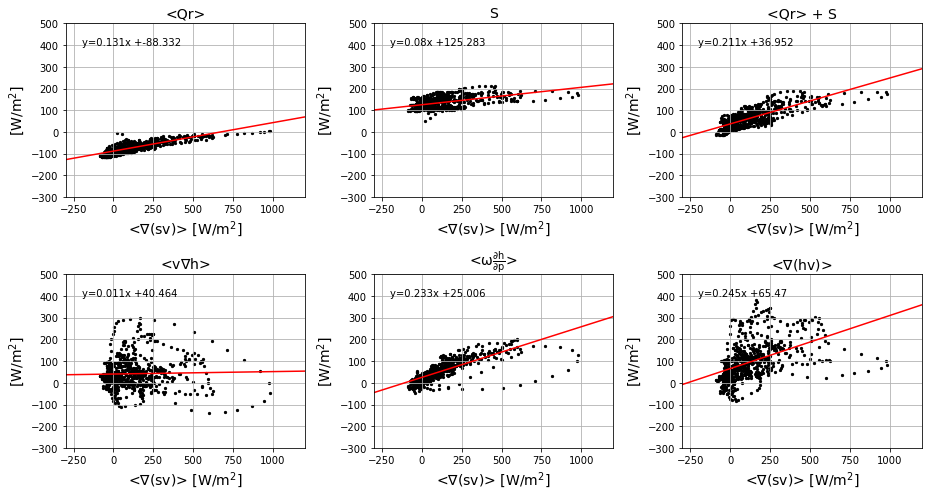

In [46]:
fig,ax = plt.subplots(2,3,figsize=(13,7))
ax_i = [0,0,0,1,1,1]; ax_j = [0,1,2,0,1,2]
titles = ['<Qr>','S','<Qr> + S',r'<v$\nabla$h>',r'<$\rm\omega \frac{\partial\rm h}{\partial\rm p}$>',r'<$\nabla$(hv)>']

for n, var in enumerate([qr_net_E5, S_E5, F_E5, vint_hadv_E5, vint_wdhdp_E5, vint_del_hv_E5]):
    
    i = ax_i[n]; j = ax_j[n]
    ax[i,j].scatter(vint_del_sv_E5,var,s=5,color='k')
    v1 = vint_del_sv_E5.flatten()
    v2 = var.flatten()
    # linear fitting
    slp,yint = np.polyfit(v1[~np.isnan(v1)],v2[~np.isnan(v1)],deg=1)
    ax[i,j].plot(np.linspace(-300,1200,100),slp*np.linspace(-300,1200,100)+yint,'r')
    ax[i,j].text(-200,400,'y='+str(round(slp,3))+'x +'+str(round(yint,3)))
    
    ax[i,j].set_xlim([-300,1200])
    ax[i,j].set_ylim([-300,500])
    ax[i,j].grid()
    ax[i,j].set_ylabel('[W/m$^2$]',fontsize=14)
    ax[i,j].set_xlabel(r'<$\nabla$(sv)> [W/m$^2$]',fontsize=14)
    ax[i,j].set_title(titles[n],fontsize=14)
plt.tight_layout()

In [47]:
# # remove SW < 10 W/m^2, OBS
# idx_rm = np.where(vint_del_sv>-1000)[0]

# M = M[idx_rm]
# Mc = Mc[idx_rm]
# Md = M - Mc
# qr_net = qr_net[idx_rm]
# F = F[idx_rm]
# vint_del_sv = vint_del_sv[idx_rm]
# vint_del_hv = vint_del_hv[idx_rm]
# vint_sadv = vint_sadv[idx_rm]
# vint_hadv = vint_hadv[idx_rm]
# vint_wdhdp = vint_wdhdp[idx_rm]
# vint_wdsdp = vint_wdsdp[idx_rm]
# prec = prec[idx_rm]

# # thermo
# T = T[idx_rm]
# q = q[idx_rm]
# rh = rh[idx_rm]
# omega = omega[idx_rm]

# # remove SW < 10W/m^2, MERRA2
# idx_rm2 = np.where(vint_del_sv_M2>-1000)[0]

# M_M2 = M_M2[idx_rm2]
# Mc_M2 = Mc_M2[idx_rm2]
# Md_M2 = M_M2 - Mc_M2
# qr_net_M2 = qr_net_M2[idx_rm2]
# F_M2 = F_M2[idx_rm2]
# vint_del_sv_M2 = vint_del_sv_M2[idx_rm2]
# vint_del_hv_M2 = vint_del_hv_M2[idx_rm2]
# vint_sadv_M2 = vint_sadv_M2[idx_rm2]
# vint_hadv_M2 = vint_hadv_M2[idx_rm2]
# vint_wdhdp_M2 = vint_wdhdp_M2[idx_rm2]
# vint_wdsdp_M2 = vint_wdsdp_M2[idx_rm2]
# prec_M2 = prec_M2[idx_rm2]

# T_M2 = T_M2[idx_rm2]
# q_M2 = q_M2[idx_rm2]
# rh_M2 = rh_M2[idx_rm2]
# omega_M2 = omega_M2[idx_rm2]

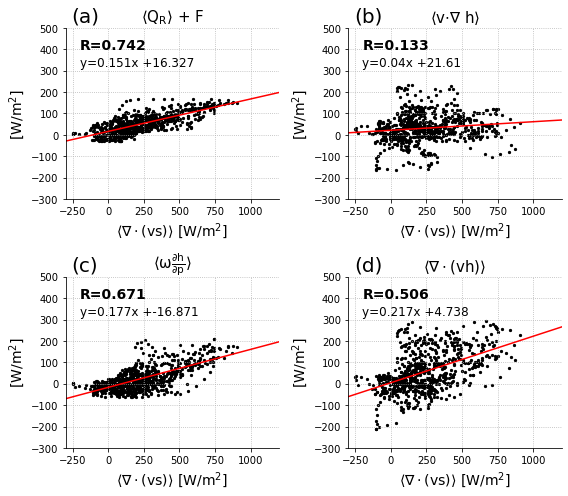

In [53]:
fig,ax = plt.subplots(2,2,figsize=(8,7))
ax_i = [0,0,1,1]; ax_j = [0,1,0,1]
titles = [r'$\langle$Q$\rm_R$$\rangle$ + F',r'$\langle$v$\cdot\nabla$ h$\rangle$',r'$\langle$$\rm\omega \frac{\partial\rm h}{\partial\rm p}$$\rangle$'
          ,r'$\langle$$\nabla\cdot$(vh)$\rangle$']
fig_num = ['(a)','(b)','(c)','(d)']

for n, var in enumerate([F, vint_hadv, vint_wdhdp, vint_hadv+vint_wdhdp]):
    
    i = ax_i[n]; j = ax_j[n]
    ax[i,j].scatter(vint_del_sv,var,s=5,color='k')
    # linear fitting
    slp,yint,r,p_val,std_err = linregress(vint_del_sv,var)
    
    ax[i,j].plot(np.linspace(-300,1200,100),slp*np.linspace(-300,1200,100)+yint,'r')
    # annotation
    ax[i,j].text(-200,400,'R='+str(round(r,3)),fontsize=14,fontweight='bold')
    ax[i,j].text(-200,320,'y='+str(round(slp,3))+'x +'+str(round(yint,3)),fontsize=12)
    
    ax[i,j].set_xlim([-300,1200])
    ax[i,j].set_ylim([-300,500])
    ax[i,j].set_ylabel('[W/m$^2$]',fontsize=14)
    ax[i,j].set_xlabel(r'$\langle$$\nabla\cdot$(vs)$\rangle$ [W/m$^2$]',fontsize=14)
    ax[i,j].set_title(titles[n],fontsize=15)
    ax[i,j].text(-260,530,fig_num[n],fontsize=20)
    ax[i,j].spines['right'].set_visible(False)
    ax[i,j].spines['top'].set_visible(False)
    ax[i,j].grid(linestyle=':')
    
plt.tight_layout()
fig.savefig('/data/willytsai/ISCCP/fig/FigureA3_TM2022.pdf',dpi=300,bbox_inches='tight',transparent=False)

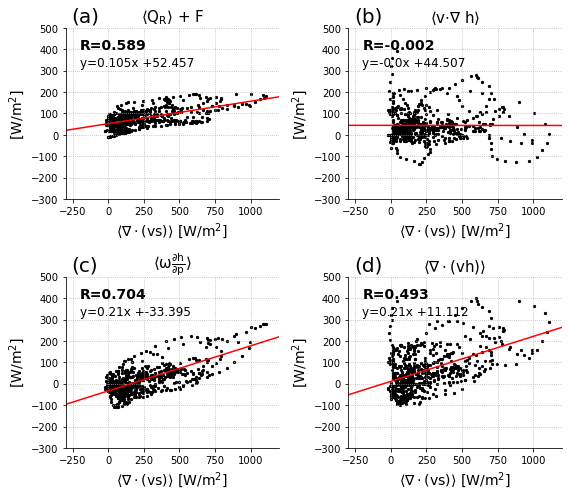

In [54]:
# MERRA2
fig,ax = plt.subplots(2,2,figsize=(8,7))
ax_i = [0,0,1,1]; ax_j = [0,1,0,1]
titles = [r'$\langle$Q$\rm_R$$\rangle$ + F',r'$\langle$v$\cdot\nabla$ h$\rangle$',r'$\langle$$\rm\omega \frac{\partial\rm h}{\partial\rm p}$$\rangle$'
          ,r'$\langle$$\nabla\cdot$(vh)$\rangle$']
fig_num = ['(a)','(b)','(c)','(d)']

for n, var in enumerate([F_M2, vint_hadv_M2, vint_wdhdp_M2, vint_hadv_M2+vint_wdhdp_M2]):
    
    i = ax_i[n]; j = ax_j[n]
    ax[i,j].scatter(vint_del_sv_M2,var,s=5,color='k')
    # linear fitting
    v1 = vint_del_sv_M2.flatten()
    v2 = var.flatten()
    slp,yint,r,p_val,std_err = linregress(v1[~np.isnan(v1)],v2[~np.isnan(v1)])
    
    ax[i,j].plot(np.linspace(-300,1200,100),slp*np.linspace(-300,1200,100)+yint,'r')
    # annotation
    ax[i,j].text(-200,400,'R='+str(round(r,3)),fontsize=14,fontweight='bold')
    ax[i,j].text(-200,320,'y='+str(round(slp,3))+'x +'+str(round(yint,3)),fontsize=12)
    
    ax[i,j].set_xlim([-300,1200])
    ax[i,j].set_ylim([-300,500])
    ax[i,j].set_ylabel('[W/m$^2$]',fontsize=14)
    ax[i,j].set_xlabel(r'$\langle$$\nabla\cdot$(vs)$\rangle$ [W/m$^2$]',fontsize=14)
    ax[i,j].set_title(titles[n],fontsize=15)
    ax[i,j].text(-260,530,fig_num[n],fontsize=20)
    ax[i,j].spines['right'].set_visible(False)
    ax[i,j].spines['top'].set_visible(False)
    ax[i,j].grid(linestyle=':')
    
plt.tight_layout()
fig.savefig('/data/willytsai/ISCCP/fig/FigureA4_TM2022.pdf',dpi=300,bbox_inches='tight',transparent=False)

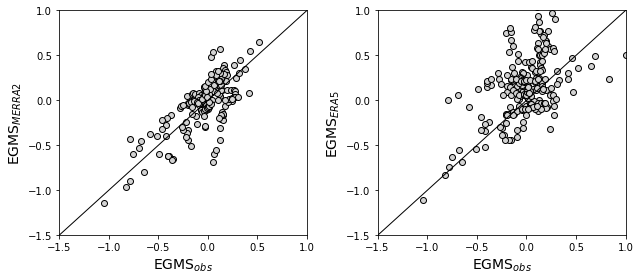

In [50]:
###### EGMS one-to-one comparision 
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,4))

idx_pp = np.where(prec>10)
EGMS_obs = (M-Mc)[idx_pp]
EGMS_M2 = (M_M2-Mc_M2)[idx_pp]
EGMS_E5 = (M_E5-Mc_E5)[idx_pp]

ax1.scatter(EGMS_obs,EGMS_M2,facecolor='lightgrey',edgecolor='k')
ax2.scatter(EGMS_obs,EGMS_E5,facecolor='lightgrey',edgecolor='k')
ax1.plot(np.linspace(-1.5,1,10),np.linspace(-1.5,1,10),'k',linewidth=1)
ax2.plot(np.linspace(-1.5,1,10),np.linspace(-1.5,1,10),'k',linewidth=1)

ax1.set_xlim([-1.5,1])
ax1.set_ylim([-1.5,1])
ax1.set_xlabel('EGMS$_{obs}$',fontsize=14)
ax1.set_ylabel('EGMS$_{MERRA2}$',fontsize=14)

ax2.set_xlim([-1.5,1])
ax2.set_ylim([-1.5,1])
ax2.set_xlabel('EGMS$_{obs}$',fontsize=14)
ax2.set_ylabel('EGMS$_{ERA5}$',fontsize=14)
plt.tight_layout()
fig.savefig('/data/willytsai/ISCCP/fig/EGMScomps_M2E5_Snds_P10.pdf',bbox_inches='tight')

Text(0, 0.5, 'EGMS_ERA5')

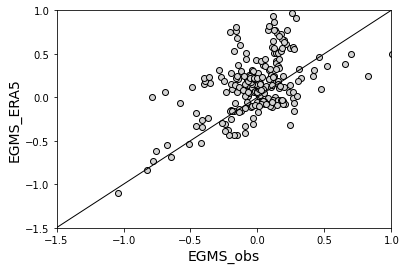

In [51]:
# Reviewer1 CERES vs M2 radiation
idx_pp = np.where(prec>10)
EGMS_obs = (M-Mc)[idx_pp]
EGMS_E5 = (M_E5-Mc_E5)[idx_pp]

plt.scatter(EGMS_obs,EGMS_E5,facecolor='lightgrey',edgecolor='k')
plt.plot(np.linspace(-1.5,1,10),np.linspace(-1.5,1,10),'k',linewidth=1)
#slp,yint,r,p_val,std_err = linregress((M-Mc)[idx_pp],(M_M2-Mc_M2)[idx_pp])
#plt.plot(np.linspace(-300,1200,100),slp*np.linspace(-300,1200,100)+yint,'r')
# annotation
#plt.text(-1.3,0.8,'R='+str(round(r,3)),fontsize=14,fontweight='bold')
#plt.text(-1.3,0.6,'y='+str(round(slp,3))+'x +'+str(round(yint,3)),fontsize=12)
plt.xlim([-1.5,1])
plt.ylim([-1.5,1])
plt.xlabel('EGMS_obs',fontsize=14)
plt.ylabel('EGMS_ERA5',fontsize=14)
#fig.savefig('/data/willytsai/ISCCP/fig/EGMScomps_ERA5_Snds_P10.pdf',bbox_inches='tight')

In [ ]:
# M-Mc, sorted array by Md = M-Mc
M_rm = M[idx_test]
Mc_rm = Mc[idx_test]
Md_rm = M_rm - Mc_rm
qr_net_rm = qr_net[idx_test]
F_rm = F[idx_test]
vint_del_sv_rm = vint_del_sv[idx_test]
vint_del_hv_rm = vint_del_hv[idx_test]
vint_sadv_rm = vint_sadv[idx_test]
vint_hadv_rm = vint_hadv[idx_test]
vint_wdhdp_rm = vint_wdhdp[idx_test]
vint_wdsdp_rm = vint_wdsdp[idx_test]
prec_rm = prec[idx_test]

T_rm = T[idx_test]
q_rm = q[idx_test]
rh_rm = rh[idx_test]
omega_rm = omega[idx_test]
#------

M_M2_rm = M_M2[idx_test2]
Mc_M2_rm = Mc_M2[idx_test2]
Mc_ce_rm = Mc_ce[idx_test2]
Md_M2_rm = M_M2_rm - Mc_M2_rm
Md_ce_rm = M_M2_rm - Mc_ce_rm
qr_net_M2_rm = qr_net_M2[idx_test2]
F_M2_rm = F_M2[idx_test2]
F_ce_rm = F_ce[idx_test2]
vint_del_sv_M2_rm = vint_del_sv_M2[idx_test2]
vint_del_hv_M2_rm = vint_del_hv_M2[idx_test2]
vint_sadv_M2_rm = vint_sadv_M2[idx_test2]
vint_hadv_M2_rm = vint_hadv_M2[idx_test2]
vint_wdhdp_M2_rm = vint_wdhdp_M2[idx_test2]
vint_wdsdp_M2_rm = vint_wdsdp_M2[idx_test2]
prec_M2_rm = prec_M2[idx_test2]

T_M2_rm = T_M2[idx_test2]
q_M2_rm = q_M2[idx_test2]
rh_M2_rm = rh_M2[idx_test2]
omega_M2_rm = omega_M2[idx_test2]

In [ ]:
# grouping into 10
group_bins = np.percentile(Md_rm,np.arange(0,100,10))
prec_bins = np.zeros(10)
Md_bins = np.zeros(10)

for n in range(10):
    if n < 9:
        idx = np.where(np.logical_and(Md_rm>=group_bins[n], Md_rm<=group_bins[n+1]))[0]
        prec_bins[n] = np.nanmean(prec_rm[idx])
        Md_bins[n] = np.nanmean(Md_rm[idx])
    else:
        idx = np.where(Md_rm>=group_bins[n])[0]
        prec_bins[n] = np.nanmean(prec_rm[idx])    
        Md_bins[n] = np.nanmean(Md_rm[idx])

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(6,6))
ax[0].plot(Md_bins,np.gradient(prec_bins,1),'-ok')
ax[1].plot(Md_bins,prec_bins,'-ok')
ax[0].set_xlim([-2.5,2]);ax[1].set_xlim([-2.5,2])
ax[0].set_ylabel('$\delta$ P [mm]',fontsize=14)
ax[1].set_ylabel('Prec [mm/d]',fontsize=14)
ax[1].set_xlabel('M-M$_c$',fontsize=14)
ax[0].grid();ax[1].grid()
ax[1].set_ylim([3,18.5])

In [ ]:
# os.chdir('/data/willytsai/ISCCP/')
# np.save('Dynamo_prec_Md.npy',prec_bins)
# np.save('Dynamo_Mdbins_Md.npy',Md_bins)

In [ ]:
# grouping into 10, MERRA2
group_bins2 = np.percentile(Md_ce_rm,np.arange(0,100,10))
prec_bins2 = np.zeros(10)
Md_bins2 = np.zeros(10)

for n in range(10):
    if n < 9:
        idx = np.where(np.logical_and(Md_ce_rm>=group_bins2[n], Md_ce_rm<=group_bins2[n+1]))[0]
        prec_bins2[n] = np.nanmean(prec_M2_rm[idx])
        Md_bins2[n] = np.nanmean(Md_ce_rm[idx])
    else:
        idx = np.where(Md_ce_rm>=group_bins2[n])[0]
        prec_bins2[n] = np.nanmean(prec_M2_rm[idx])    
        Md_bins2[n] = np.nanmean(Md_ce_rm[idx])

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(6,6))
ax[0].plot(Md_bins2,np.gradient(24*3600*prec_bins2,1),'-ob')
ax[1].plot(Md_bins2,24*3600*prec_bins2,'-ob')
ax[0].set_xlim([-2.5,2]);ax[1].set_xlim([-2.5,2])
ax[0].set_ylabel('$\delta$ P [mm]',fontsize=14)
ax[1].set_ylabel('Prec [mm/d]',fontsize=14)
ax[1].set_xlabel('M-M$_c$',fontsize=14)
ax[0].grid();ax[1].grid();
ax[1].set_ylim([3,18.5])

# overlapping OBS
ax[0].plot(Md_bins,np.gradient(prec_bins,1),'-ok')
ax[1].plot(Md_bins,prec_bins,'-ok')
ax[0].set_xlim([-2.5,2]);ax[1].set_xlim([-2.5,2])
ax[0].set_ylabel('$\delta$ P [mm]',fontsize=14)
ax[1].set_ylabel('Prec [mm/d]',fontsize=14)
ax[1].set_xlabel('M-M$_c$',fontsize=14)
ax[0].grid();ax[1].grid()
ax[1].set_ylim([3,18.5])

ax[1].legend(['MERRA2','OBS'])
ax[0].grid();ax[1].grid()

### Characteristics of T, q, RH, div in EGMS space

In [ ]:
def vars_Mspace(var_rm, Md_rm, lev=40, bin_width=20, opt=1):
    
    group_bins = np.percentile(Md_rm,np.arange(0,100,bin_width))
    if opt==1:
        var_bins = np.zeros(len(group_bins))
    else:
        var_bins = np.zeros((len(group_bins),lev))
    
    for n in range(len(group_bins)):
        if n < len(group_bins)-1:
            idx = np.where(np.logical_and(Md_rm>=group_bins[n], Md_rm<=group_bins[n+1]))[0]
        else:
            idx = np.where(Md_rm>=group_bins[n])[0]
        
        if opt==1:
            var_bins[n] = np.nanmean(var_rm[idx],axis=0) 
        else:
            var_bins[n,:] = np.nanmean(var_rm[idx,:],axis=0) 
            
    return var_bins

In [ ]:
def vars_Mspace_bin(var_rm, Md_rm, Md_bins, lev=40, bin_width=20, opt=1):
    
    #group_bins = np.linspace(Md_bins[0],Md_bins[-1],10)
    group_bins = np.linspace(-3,3,10)
    if opt==1:
        var_bins = np.zeros(len(group_bins))
    else:
        var_bins = np.zeros((len(group_bins),lev))
    
    for n in range(len(group_bins)):
        if n < len(group_bins)-1:
            idx = np.where(np.logical_and(Md_rm>=group_bins[n], Md_rm<=group_bins[n+1]))[0]
        else:
            idx = np.where(Md_rm>=group_bins[n])[0]
        
        if opt==1:
            var_bins[n] = np.nanmean(var_rm[idx],axis=0) 
        else:
            var_bins[n,:] = np.nanmean(var_rm[idx,:],axis=0) 
            
    return var_bins

In [ ]:
Md_dec = vars_Mspace(Md_rm, Md_rm, lev=40, bin_width=10, opt=1)
prec_dec = vars_Mspace(prec_rm, Md_rm, lev=40,bin_width=10, opt=1)
T_dec = vars_Mspace(T_rm, Md_rm, lev=40, bin_width=10, opt=2)
rh_dec = vars_Mspace(rh_rm, Md_rm, lev=40, bin_width=10, opt=2)
omega_dec = vars_Mspace(omega_rm, Md_rm, lev=40, bin_width=10, opt=2)

In [ ]:
Md_dec = vars_Mspace_bin(Md_rm, Md_rm, Md_bins, lev=40, bin_width=10, opt=1)
prec_dec = vars_Mspace_bin(prec_rm, Md_rm, Md_bins, lev=40,bin_width=10, opt=1)
T_dec = vars_Mspace_bin(T_rm, Md_rm, Md_bins, lev=40, bin_width=10, opt=2)
rh_dec = vars_Mspace_bin(rh_rm, Md_rm, Md_bins, lev=40, bin_width=10, opt=2)
omega_dec = vars_Mspace_bin(omega_rm, Md_rm, Md_bins, lev=40, bin_width=10, opt=2)

In [ ]:
group_bins = np.linspace(-3,3,10)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(group_bins,prec_dec,'-o')
cbar = ax[1].contourf(group_bins,lev,omega_dec.T,np.linspace(-0.14,0.14,29),cmap='RdBu_r')
ax[1].contour(group_bins,lev,omega_dec.T,np.linspace(-0.14,0.14,15),colors=['k'],linewidths=0.8)
for n in range(10):
    ax[1].plot(Md_bins[n],1000,'^m',zorder=3,markersize=10)
#plt.colorbar(cbar,ax=ax[1])

ax[1].set_ylim([1000,100])
ax[0].set_xlim([-2.5,2]);ax[1].set_xlim([-2.5,2])

In [ ]:
Md_M2_dec = vars_Mspace_bin(Md_M2_rm, Md_ce_rm, Md_bins2, 42, bin_width=10, opt=1)
prec_M2_dec = vars_Mspace_bin(prec_M2_rm, Md_ce_rm, Md_bins2, 42, bin_width=10, opt=1)
T_M2_dec = vars_Mspace_bin(T_M2_rm, Md_ce_rm, Md_bins2, 42, bin_width=10, opt=2)
rh_M2_dec = vars_Mspace_bin(rh_M2_rm, Md_ce_rm, Md_bins2, 42, bin_width=10, opt=2)
omega_M2_dec = vars_Mspace_bin(omega_M2_rm, Md_ce_rm, Md_bins2, 42, bin_width=10, opt=2)

In [ ]:
group_bins2 = np.linspace(-3,3,10)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3.5))

cf1 = ax[0].contourf(group_bins,lev,omega_dec.T,np.linspace(-0.14,0.14,29),cmap='RdBu_r')
c1 = ax[0].contour(group_bins,lev,omega_dec.T,np.linspace(-0.14,0.14,15),colors=['k'],linewidths=0.8)
ax[0].contour(group_bins,lev,omega_dec.T,[0],colors=['k'],linewidths=1.5)
for n in range(10):
    ax[0].plot(Md_bins[n],1000,'^g',zorder=3,markersize=13)
#cb1 = plt.colorbar(cf1,ax=ax[0],shrink=0.8)
#cb1.set_label('[Pa/s]',fontsize=12)

cf2 = ax[1].contourf(group_bins2,lev_M2,omega_M2_dec.T,levels=np.linspace(-0.14,0.14,29),cmap='RdBu_r')
c1 = ax[1].contour(group_bins2,lev_M2,omega_M2_dec.T,levels=np.linspace(-0.14,0.14,15),colors=['k'],linewidths=0.8)
ax[1].contour(group_bins2,lev_M2,omega_M2_dec.T,[0],colors=['k'],linewidths=1.5)
for n in range(10):
    ax[1].plot(Md_bins2[n],1000,'^g',zorder=3,markersize=13)
#cb2 = plt.colorbar(cf2,ax=ax[1],shrink=0.8)
#cb2.set_label('[Pa/s]',fontsize=12)
# axp2 = ax[1].twinx()

ax[0].set_ylim([1000,100]);ax[1].set_ylim([1000,100])
ax[0].set_xlim([-2.5,2]);ax[1].set_xlim([-2.5,2])
ax[0].vlines(x=0,ymin=100,ymax=1000,linewidth=0.8,color='grey')
ax[1].vlines(x=0,ymin=100,ymax=1000,linewidth=0.8,color='grey')

cbaxes = inset_axes(ax[1], width="5%",height="70%",loc='upper left',
           bbox_to_anchor=(1.05, -0.16, 1, 1),bbox_transform=ax[1].transAxes,
           borderpad=0) 
cbar=fig.colorbar(cf1,cax=cbaxes,orientation='vertical')
cbar.set_label('[Pa/s]',fontsize=14)

# text section
ax[0].set_xlabel(r'M-M$\rm_d$',fontsize=15);ax[0].set_ylabel('[hPa]',fontsize=14)
ax[1].set_xlabel(r'M-M$\rm_d$',fontsize=15);ax[1].set_ylabel('[hPa]',fontsize=14)
ax[0].set_title('(a) OBS',fontsize=18,loc='left');ax[1].set_title('(b) MERRA2',fontsize=18,loc='left');
#ax[0].tick_params(labelsize=11);ax[1].tick_params(labelsize=11);
fig.savefig('/data/willytsai/ISCCP/fig/Omega_EGMS_compare.pdf',bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,3.5))

cbar1 = ax[0].contourf(group_bins,lev,rh_dec.T,np.linspace(40,90,11),cmap='jet')
ax[0].contour(group_bins,lev,rh_dec.T,np.linspace(40,90,11),colors=['k'],linewidths=0.8)
for n in range(10):
    ax[0].plot(Md_bins[n],1000,'^m',zorder=3,markersize=10)
plt.colorbar(cbar1,ax=ax[0])

cbar2 = ax[1].contourf(group_bins2,lev_M2,100*rh_M2_dec.T,np.linspace(40,90,11),cmap='jet')
ax[1].contour(group_bins2,lev_M2,100*rh_M2_dec.T,np.linspace(40,90,11),colors=['k'],linewidths=0.8)
for n in range(10):
    ax[1].plot(Md_bins2[n],1000,'^m',zorder=3,markersize=10)
plt.colorbar(cbar2,ax=ax[1])

ax[0].set_ylim([1000,100]);ax[1].set_ylim([1000,100])
ax[0].set_xlim([-2.5,2]);ax[1].set_xlim([-2.5,2])

# text section
ax[0].set_xlabel('M-M$_c$',fontsize=14);ax[0].set_ylabel('[hPa]',fontsize=14)
ax[1].set_xlabel('M-M$_c$',fontsize=14);ax[1].set_ylabel('[hPa]',fontsize=14)
ax[0].set_title('(a) OBS',fontsize=14,loc='left');ax[1].set_title('(b) MERRA2',fontsize=14,loc='left');

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(group_bins,prec_dec,'-o')
cbar = ax[1].contourf(group_bins,lev,omega_dec.T,np.linspace(-0.14,0.14,29),cmap='RdBu_r')
ax[1].contour(group_bins,lev,omega_dec.T,np.linspace(-0.14,0.14,15),colors=['k'],linewidths=0.8)
for n in range(10):
    ax[1].plot(Md_bins[n],1000,'^m',zorder=3,markersize=10)
#plt.colorbar(cbar,ax=ax[1])

ax[1].set_ylim([1000,100])
ax[0].set_xlim([-2.5,2]);ax[1].set_xlim([-2.5,2])

In [ ]:
cmp=plt.cm.get_cmap('BrBG_r')
color_label=cmp(np.linspace(0.2,0.8,5))
for i,n in enumerate([0,2,4,6,8]):
    plt.plot(rh_M2_dec[n,:]*100,lev_M2,color=color_label[i],linewidth=2)
    if n == 4:
        plt.plot(rh_M2_dec[n,:]*100,lev_M2,color='dimgrey',linewidth=3)
plt.ylim([1000,100])
plt.xlim([40,100])
plt.legend(['0','2','4','6','8'])

$\frac{\partial \langle h \rangle}{\partial t} + \nabla \langle hv \rangle  = \langle Q_R \rangle + SFX $

$\frac{1}{\nabla \langle sv \rangle}\frac{\partial \langle h \rangle}{\partial t} = -\frac{\nabla \langle hv \rangle}{\nabla \langle sv \rangle} + \frac{\langle Q_R \rangle + SFX}{\nabla \langle sv \rangle}$

In [ ]:
24:56

In [ ]:
plt.plot(prec[300:700])